# Contents

[**Decision Tree**](#Decision-Tree)

[**Bias and Variance**](#Bias-and-Variance)

[**Random Forest**](#Random-Forest)

[**Gradient Boosting Trees**](#Gradient-Boosting-Trees)

[**XGBoost**](#XGBoost)

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from IPython.display import Image

In [29]:
c_turquoise = '#00ced1'
c_orange_red = '#ff4500'
c_salmon = '#fa8072'
c_royal_blue = '#4169e1'
c_emerald = '#50c878'
c_teal = '#008080'
c_grey = '#708090'
c_lilac = '#c8a2c8'
c_light_magenta = '#ff80ca'

# Decision Tree

- A Binary tree that greedily and recursively splits data into two subsets: Each internal node chooses a feature and split point
- Handles both regression and classification problems
- Handles missing data
- Easy to interpret

## A regression problem with one feature

Adapted from Peter Prettenhofer's notebook: http://nbviewer.ipython.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb

/Library/Python/2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


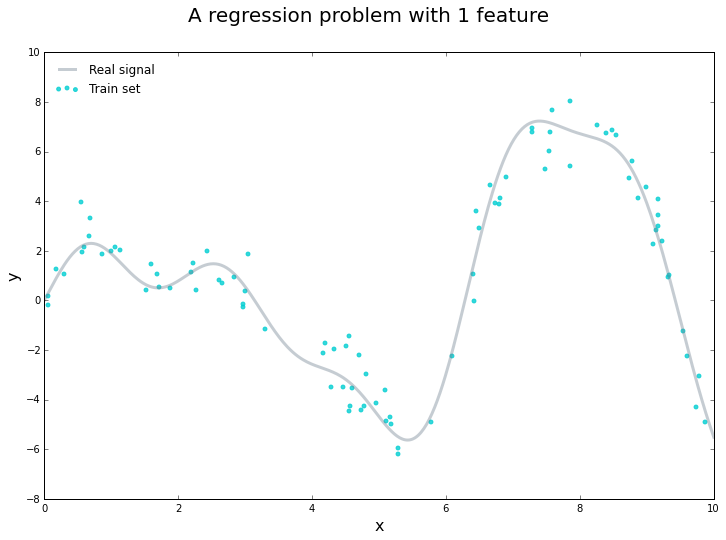

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x) + np.sin(3 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(200)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    return x_train, x_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(200)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(title='', figsize=(12, 8), plot_test=False):
    fig = plt.figure(figsize=figsize)
    gt = plt.plot(x_plot, ground_truth(x_plot), label='Real signal',
                  alpha=0.4, linewidth=3, color=c_grey)

    # plot training and testing data
    plt.scatter(X_train, y_train, s=15, alpha=0.8, color=c_turquoise, label='Train set')
    if plot_test:
        plt.scatter(X_test, y_test, s=15, alpha=0.8, color=c_orange_red, label='Test set')
    plt.xlim((0, 10))
    plt.ylabel('y', fontsize=16)
    plt.xlabel('x', fontsize=16)
    plt.suptitle(title, fontsize=20)
    
    plt.legend(loc='upper left', frameon=False)
    
plot_data(title='A regression problem with 1 feature', figsize=(12, 8))

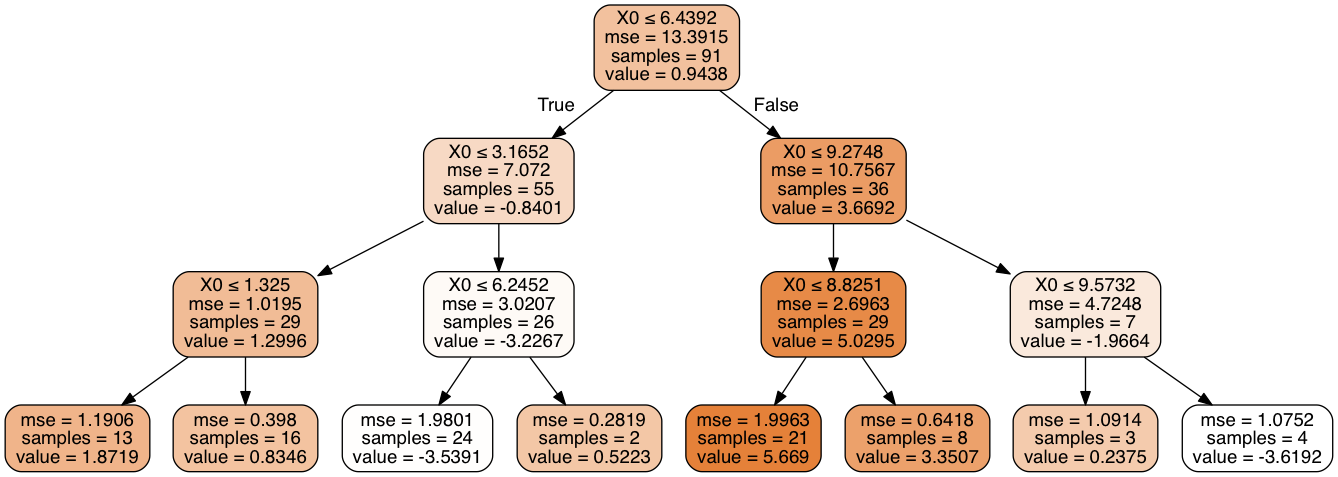

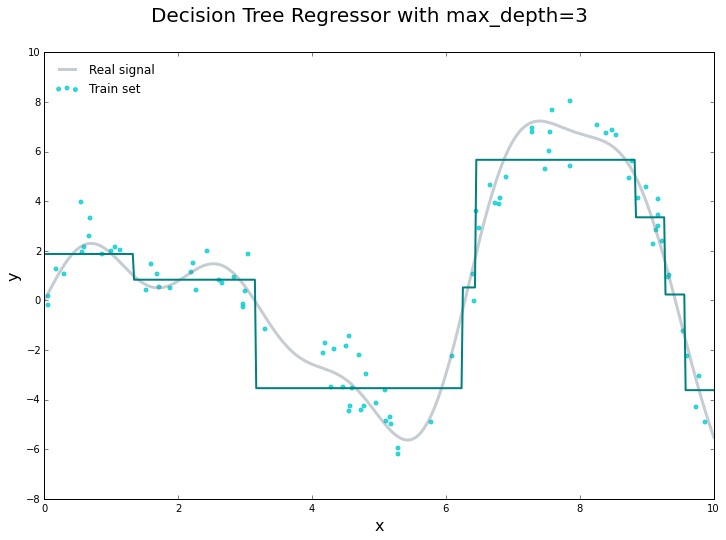

In [25]:
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot

max_depth = 3

dtr = DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
plot_data(title='Decision Tree Regressor with max_depth=%d' % max_depth)
plt.plot(x_plot, dtr.predict(x_plot[:, np.newaxis]),
         label='Decision Tree max_depth=%d' % max_depth, color=c_teal, alpha=1, linewidth=2)

dot_data = StringIO()
tree.export_graphviz(dtr, out_file=dot_data,
                     filled=True,
                     rounded=True,
                     special_characters=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png()) 

## Criterion for regression

**Mean Squared Error**
$$c = \frac{1}{N}\sum_i y_i$$
$$H = \frac{1}{N}\sum_i (y_i - c)^2$$

## Max tree depth

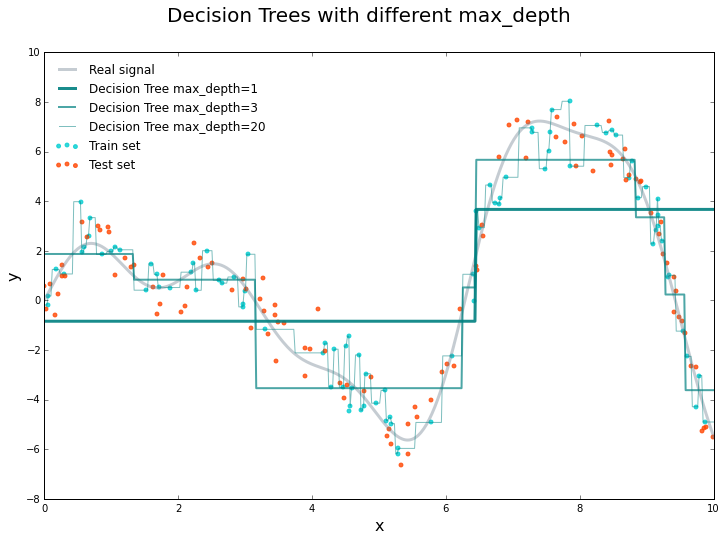

In [76]:
plot_data(title='Decision Trees with different max_depth', plot_test=True)

dtr1 = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, dtr1.predict(x_plot[:, np.newaxis]),
         label='Decision Tree max_depth=1', color=c_teal, alpha=0.9, linewidth=3)

dtr2 = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, dtr2.predict(x_plot[:, np.newaxis]),
         label='Decision Tree max_depth=3', color=c_teal, alpha=0.7, linewidth=2)

dtr3 = DecisionTreeRegressor(max_depth=20).fit(X_train, y_train)
plt.plot(x_plot, dtr3.predict(x_plot[:, np.newaxis]),
         label='Decision Tree max_depth=20', color=c_teal, alpha=0.5, linewidth=1)

plt.legend(loc='upper left', frameon=False)

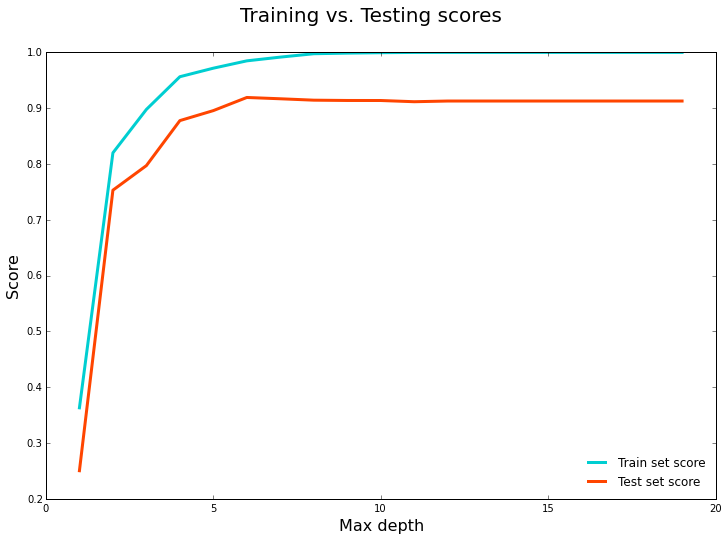

In [26]:
train_scores, test_scores = [], []
for max_depth in range(1, 20):
    model = DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(range(1, 20), train_scores, label='Train set score', color=c_turquoise, linewidth=3)
plt.plot(range(1, 20), test_scores, label='Test set score', color=c_orange_red, linewidth=3)

ax.set_ylabel('Score', fontsize=16)
ax.set_xlabel('Max depth', fontsize=16)

plt.legend(loc='lower right', frameon=False)
plt.suptitle('Training vs. Testing scores', fontsize=20)

## A classification problem with two features

Inspired by Trevor Hastie's talk: https://www.youtube.com/watch?v=wPqtzj5VZus

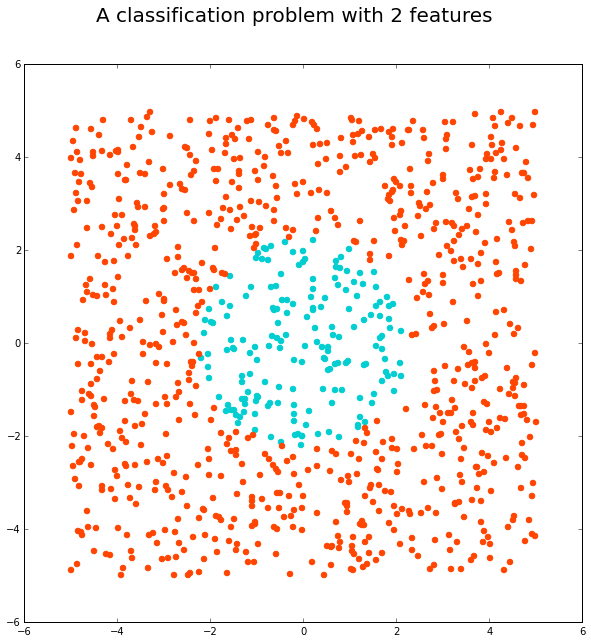

In [30]:
n_samples = 1000
np.random.seed(101)
xs = np.random.uniform(-5, 5, size=n_samples)
np.random.seed(102)
ys = np.random.uniform(-5, 5, size=n_samples)

class1_mask = np.asarray(map(lambda x: x[0] ** 2 + x[1] ** 2 <= 5, zip(xs, ys)))
x1, y1 = xs[class1_mask], ys[class1_mask]
x2, y2 = xs[~class1_mask], ys[~class1_mask]

fig = plt.figure(figsize=(10, 10))
plt.scatter(x1, y1, s=30, color=c_turquoise)
plt.scatter(x2, y2, s=30, color=c_orange_red)

plt.suptitle("A classification problem with 2 features", fontsize=20)

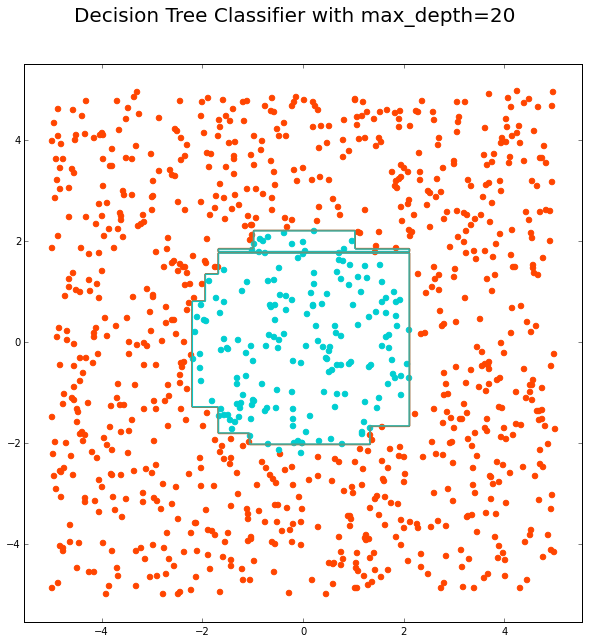

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six.moves import xrange

# Parameters
n_classes = 2
max_depth = 20
plot_colors = [c_orange_red, c_turquoise]
cmap = plt.cm.RdBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

fig = plt.figure(figsize=(10, 10))

X = np.asarray(zip(xs, ys))
y = class1_mask.astype(int)

dtc = DecisionTreeClassifier(max_depth=max_depth)
clf = dtc.fit(X, y)
scores = clf.score(X, y)

# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

pred = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)
cs = plt.contour(xx, yy, pred, colors=plot_colors, linewidth=10)
# cs = plt.contourf(xx, yy, pred, cmap=cmap, linewidth=10)

# Plot the training points
for i, c in zip(xrange(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], color=c, s=30)

plt.suptitle("Decision Tree Classifier with max_depth=%d" % max_depth, fontsize=20)
plt.axis("tight")

plt.show()

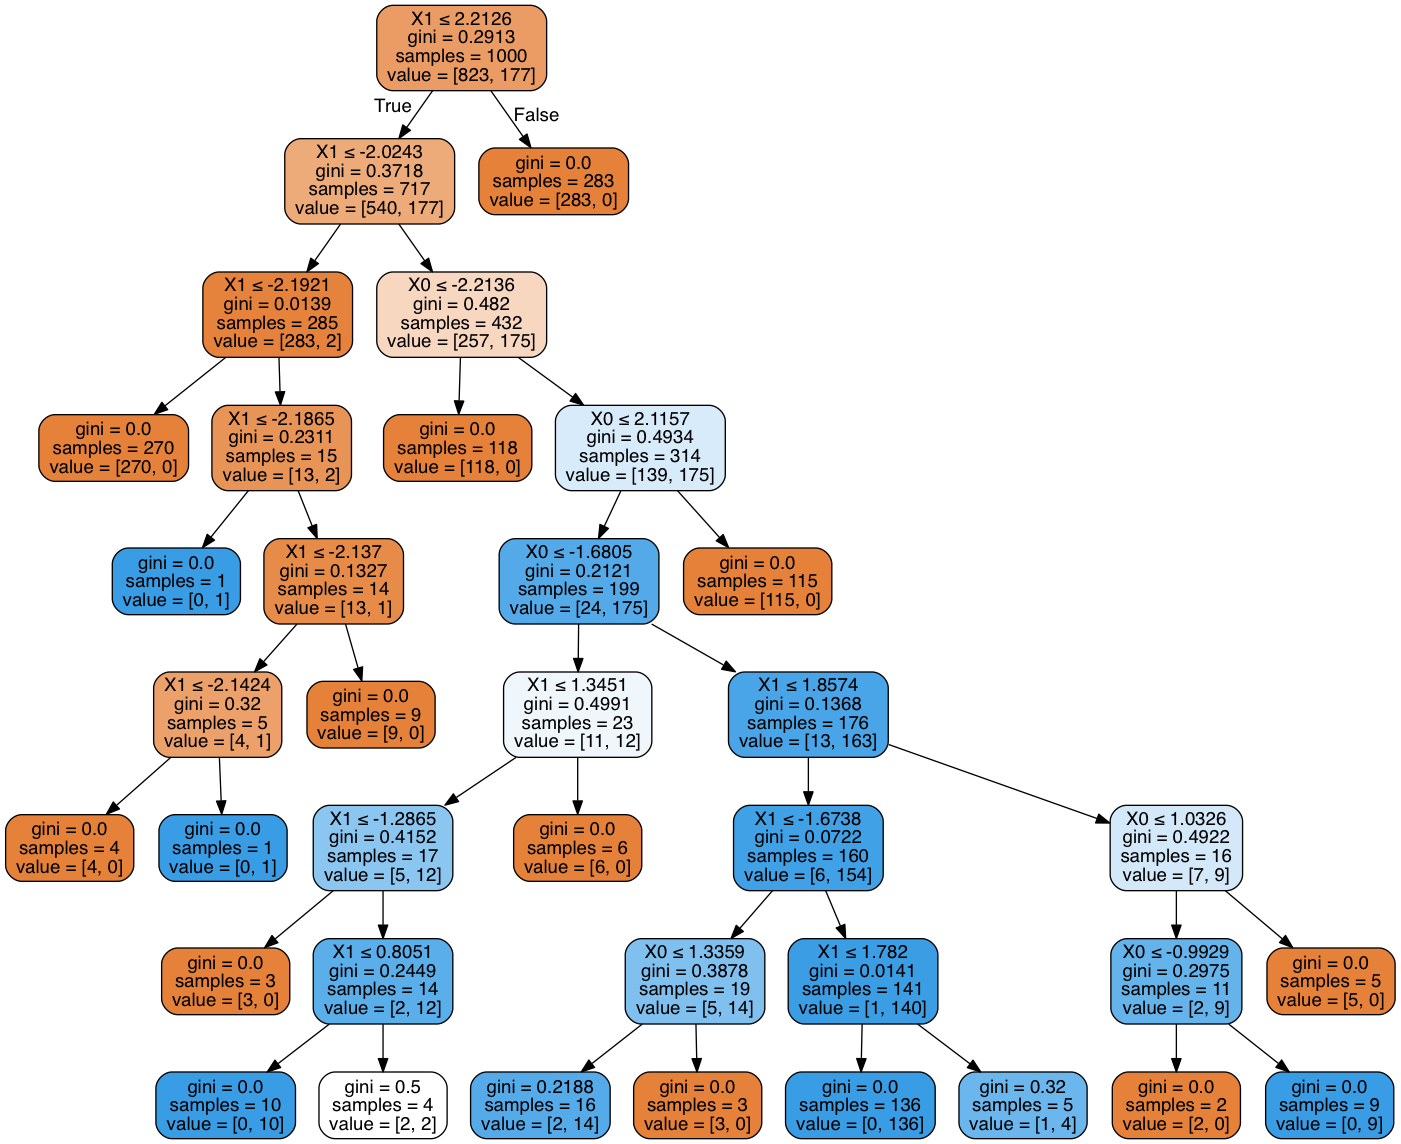

In [69]:
dot_data = StringIO()
tree.export_graphviz(dtc, out_file=dot_data,
                     filled=True,
                     rounded=True,
                     special_characters=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png()) 

## Criteria for classification

**Gini impurity**, or Gini index:
$$H = \sum_k p_k (1-p_k)$$

**Cross entropy**
$$H = -\sum_k p_k\log{p_k}$$

## Handles missing data

- Throw away rows with missing values (Uh...)
- Find a surrogate feature that best matches the primary feature, and use it when the primary feature is missing
- For categorical feature, add one factor of "missing"
- XGBoost: Put the rows with missing values in left/right child node, and compare the performance

## Single tree sucks, we need more

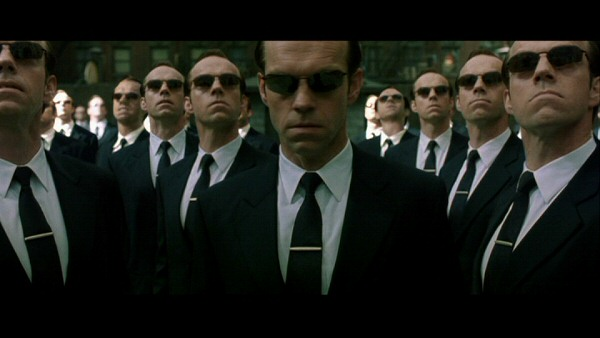

In [57]:
Image(filename='agent-smith.jpg')

# Bias and Variance

Source: http://scott.fortmann-roe.com/

**Bias**: How far the average prediction is from the true value

**Variance**: How far the predictions are from their mean

**Irreducible Error**: Noises within the training set

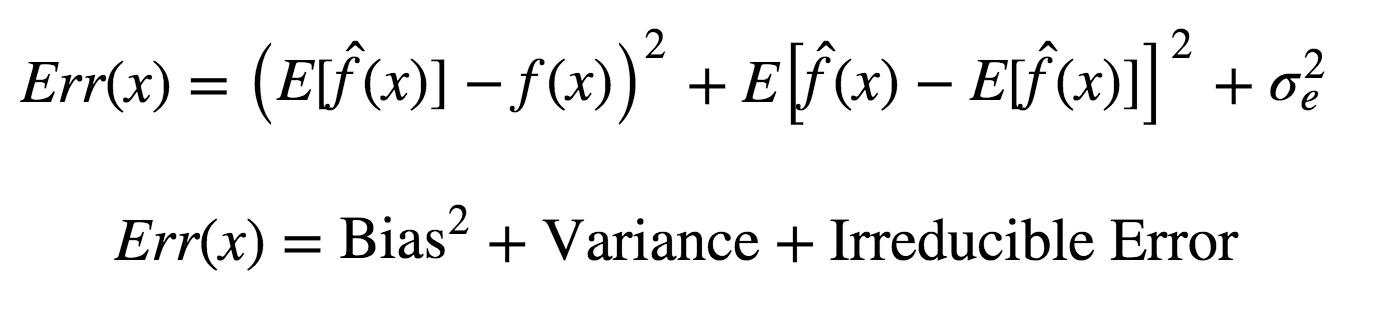

In [13]:
Image(filename='bias-var-equation.png', width=500)

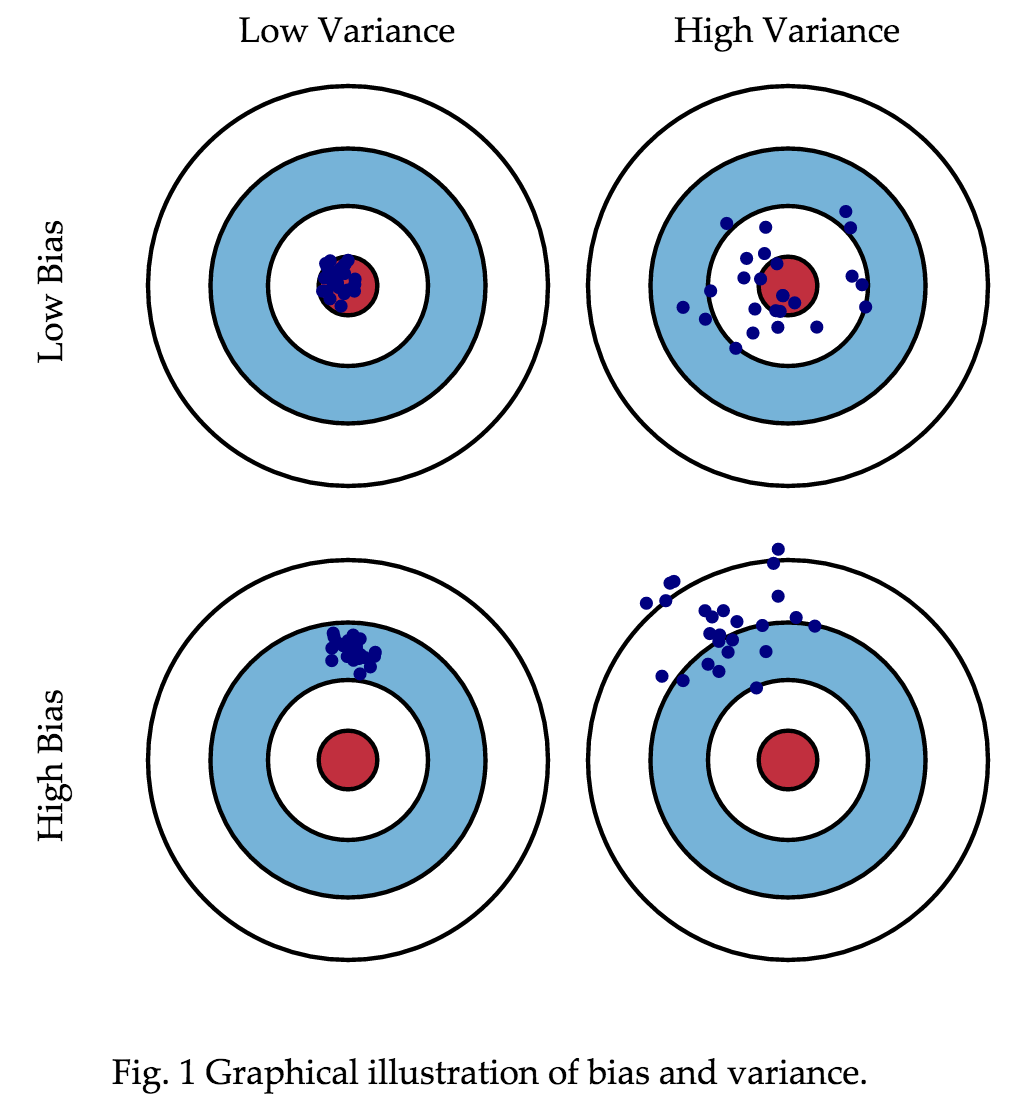

In [10]:
Image(filename='bias-variance.png', width=500)

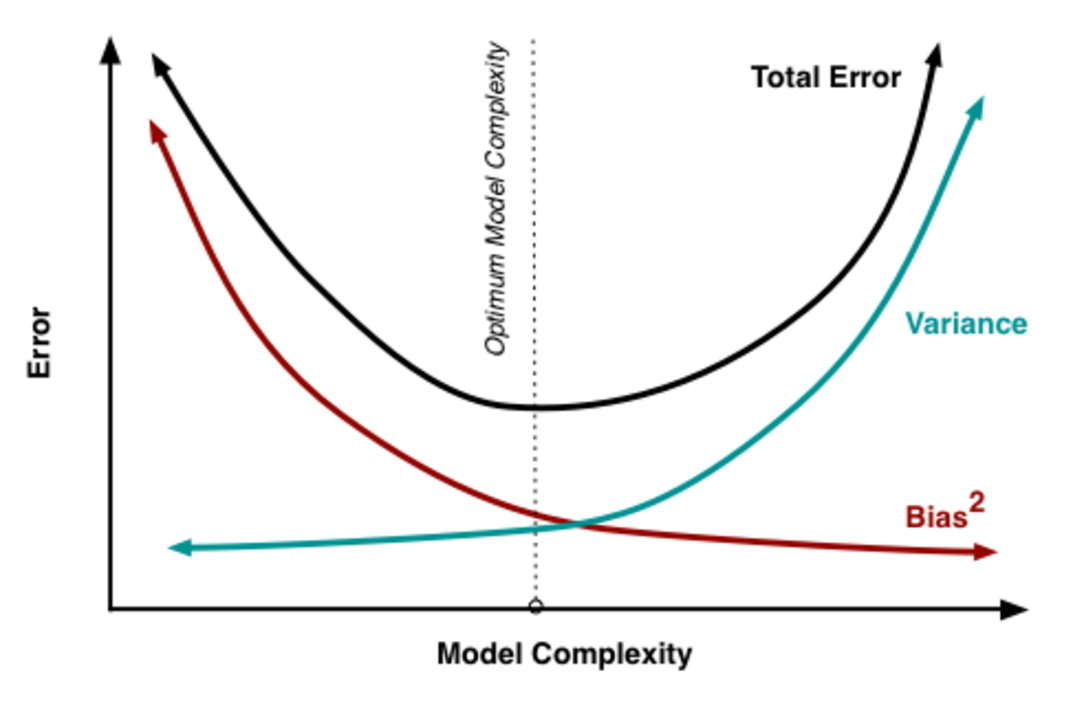

In [11]:
Image(filename='model-complexity.png', width=500)

# Random Forest

- **Bagging**: Shake up the dataset so that each tree will see slightly different data.
- **De-correlation**: Sample the features to introduce additional randomness
- **Reduce variance**: Thus reducing the overall error. Overfitting of a single tree will be corrected by other trees. More trees seldom lead to overfitting of the forest.
- **No need to have a test set!** Bootstrap will leave part of the data out (Out of the Bag, **OOB**), and that part of data can be used as a test set.

## Algorithm

Proposed by Leo Breiman, also the author of CART ![Leo Breiman](https://upload.wikimedia.org/wikipedia/en/4/4d/Leo_Breiman.jpg)

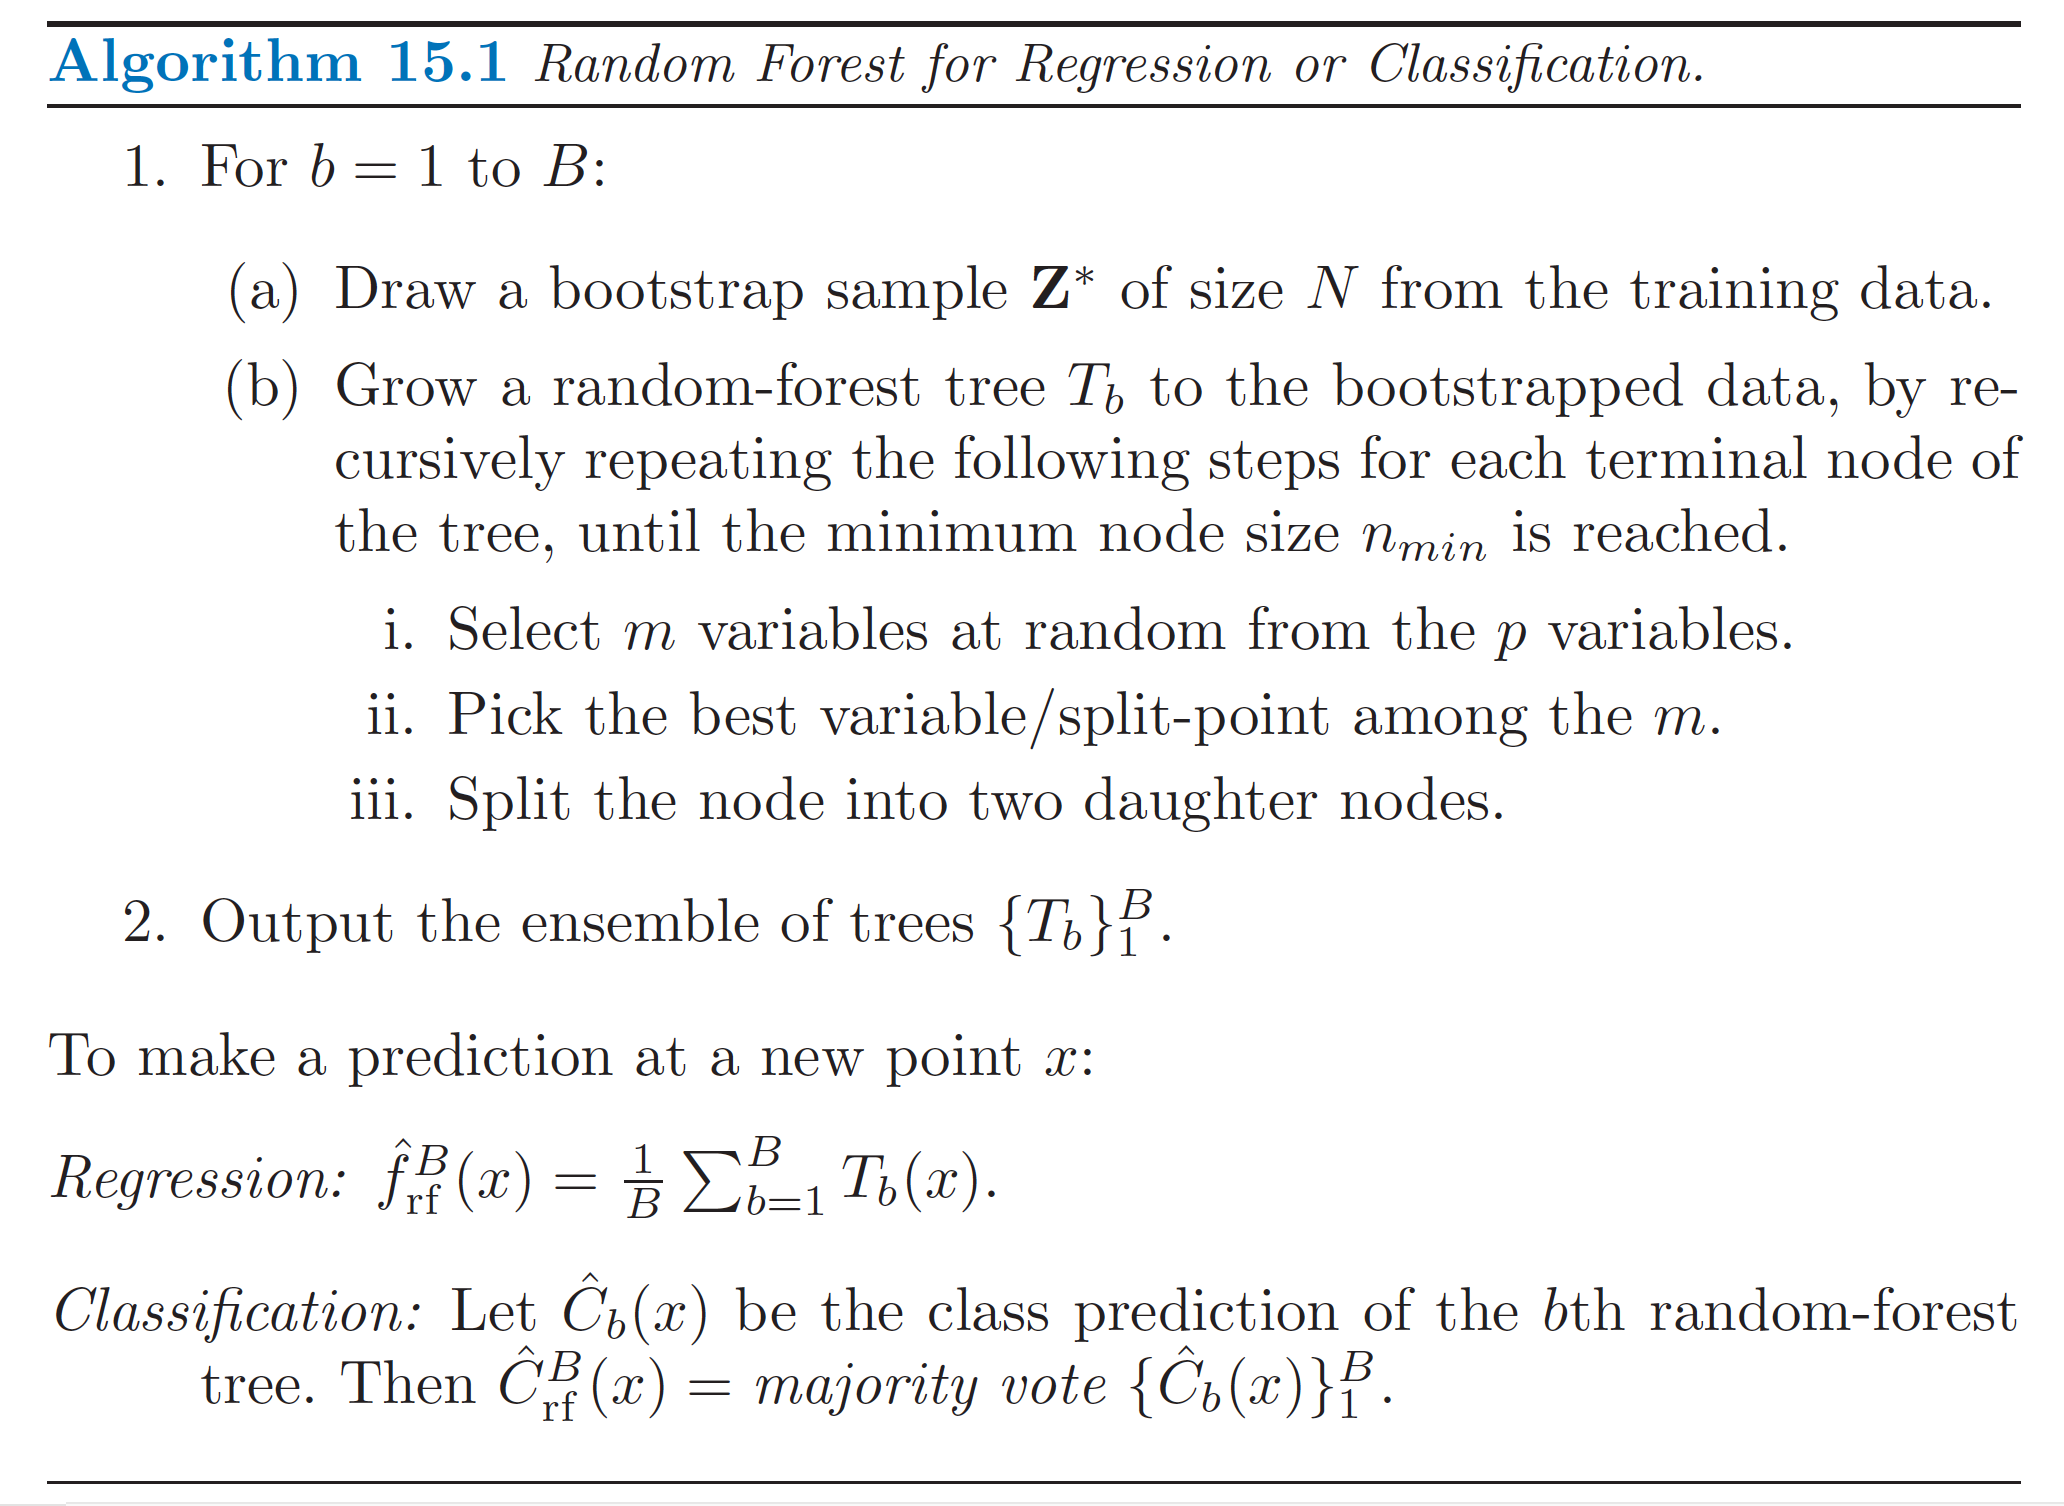

In [9]:
Image(filename='random-forest-algo.png', width=700)

## Bootstrap

Sampling with replacement, introduced by Bradley Efron

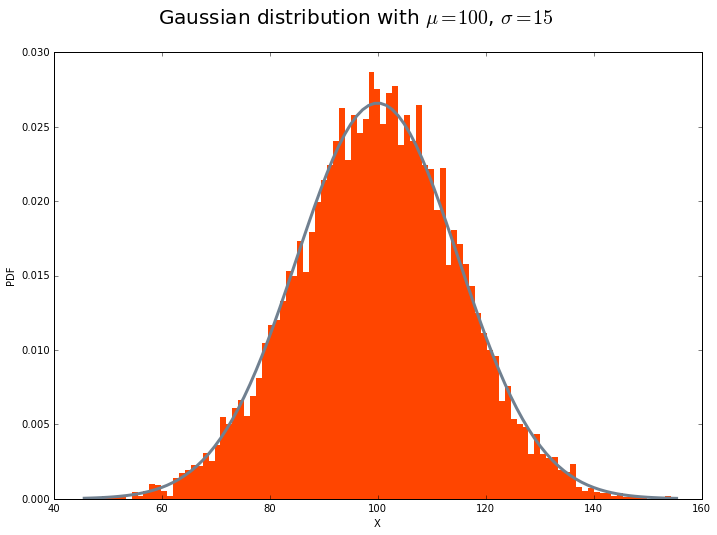

In [113]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

np.random.seed(seed=10)
# Normal distribution
mu = 100
sigma = 15
x = mu + sigma * np.random.randn(10000)

num_bins = 100
fig = plt.figure(figsize=(12, 8))
# Empirical histogram of the data
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor=c_orange_red, linewidth=0)
# Real distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, c_grey, linewidth=3)
plt.xlabel('X')
plt.ylabel('PDF')
plt.suptitle(r'Gaussian distribution with $\mu=100$, $\sigma=15$', fontsize=20)

plt.subplots_adjust(left=0.15)
plt.show()

Mean: 75.119263, Std.: 34.340162


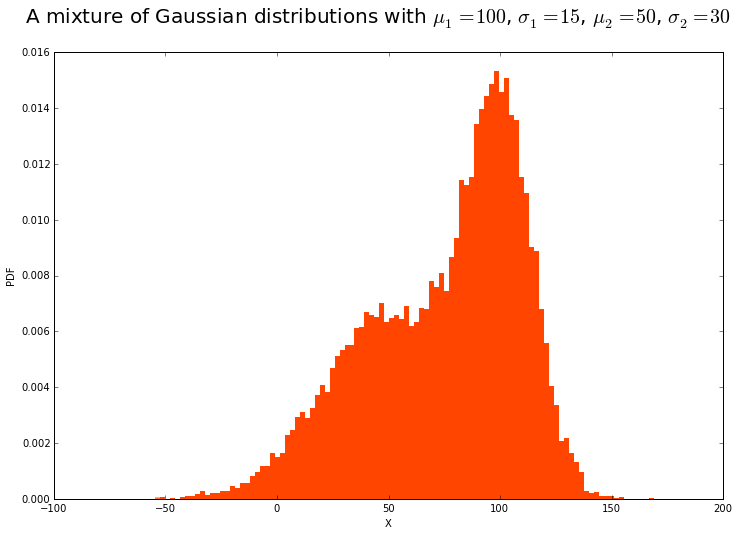

In [114]:
np.random.seed(seed=10)
x1 = 100 + 15 * np.random.randn(10000)
np.random.seed(seed=11)
x2 = 50 + 30 * np.random.randn(10000)
x3 = np.append(x1, x2)
print('Mean: %f, Std.: %f' % (np.mean(x3), np.std(x3)))

fig = plt.figure(figsize=(12, 8))
# Empirical histogram of the data
n, bins, patches = plt.hist(x3, num_bins, normed=1, facecolor=c_orange_red, linewidth=0)
# Real distribution
plt.xlabel('X')
plt.ylabel('PDF')
plt.suptitle(r'A mixture of Gaussian distributions '
              'with $\mu_1=100$, $\sigma_1=15$, $\mu_2=50$, $\sigma_2=30$',
             fontsize=20)

plt.show()

Mean: 75.433281, Std.: 34.249282


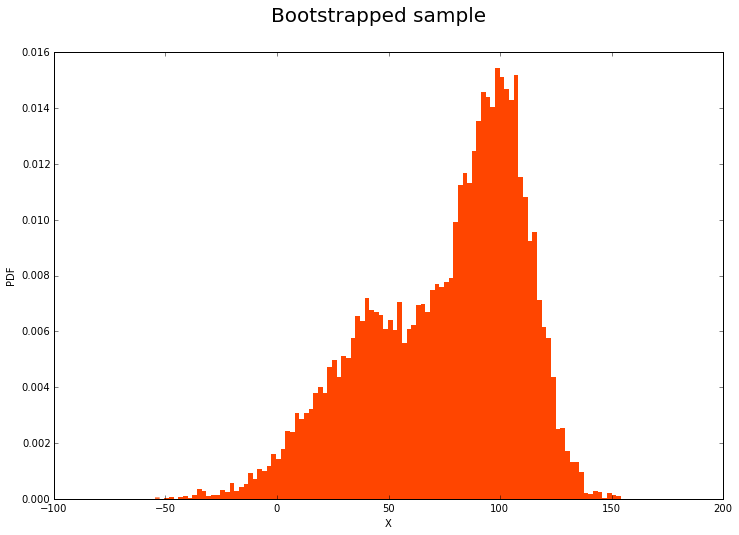

In [115]:
x4 = []
for i in range(20000):
    x4.append(np.random.choice(x3))
print('Mean: %f, Std.: %f' % (np.mean(x4), np.std(x4)))

fig = plt.figure(figsize=(12, 8))
# Empirical histogram of the data
n, bins, patches = plt.hist(x4, num_bins, normed=1, facecolor=c_orange_red, linewidth=0)
# Real distribution
plt.xlabel('X')
plt.ylabel('PDF')
plt.suptitle(r'Bootstrapped sample',
          fontsize=20)

plt.show()

Robust measures of population statistics

In [54]:
means, stds = [], []
for t in range(100):
    for i in range(20000):
        x4.append(np.random.choice(x3))
    means.append(np.mean(x4)), stds.append(np.std(x4))

print(np.mean(means), np.std(means))
print(np.mean(stds), np.std(stds))

(75.142559702015305, 0.012386308723319915)
(34.342425675588899, 0.0060153483259489391)


## Reduce noise by averaging and de-correlation

The **bias** of the forest will be the same as any individual tree, but the **variance** of the forest will be smaller.

Assume each tree $T$ has variance $\sigma^2$. The average of $N$ such trees, $\bar{T}$, has variance:
$$Var(\bar{T}) = \frac{\sigma^2}{N}$$
if they are uncorrelated.

But in fact they are often correlated! If the average correlation coefficient is $\rho$, then
$$Var(\bar{T}) = \rho\sigma^2 + \frac{1-\rho}{N}\sigma^2$$

- Increasing $N$ will decrease the variance
- De-correlating the trees by selecting a subset of features at each node will reduce $\rho$, further decreasing variance

## Trees are combined via voting

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six.moves import xrange

# Parameters
n_classes = 2
n_estimators = 30
plot_colors = [c_orange_red, c_turquoise]
cmap = plt.cm.RdBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

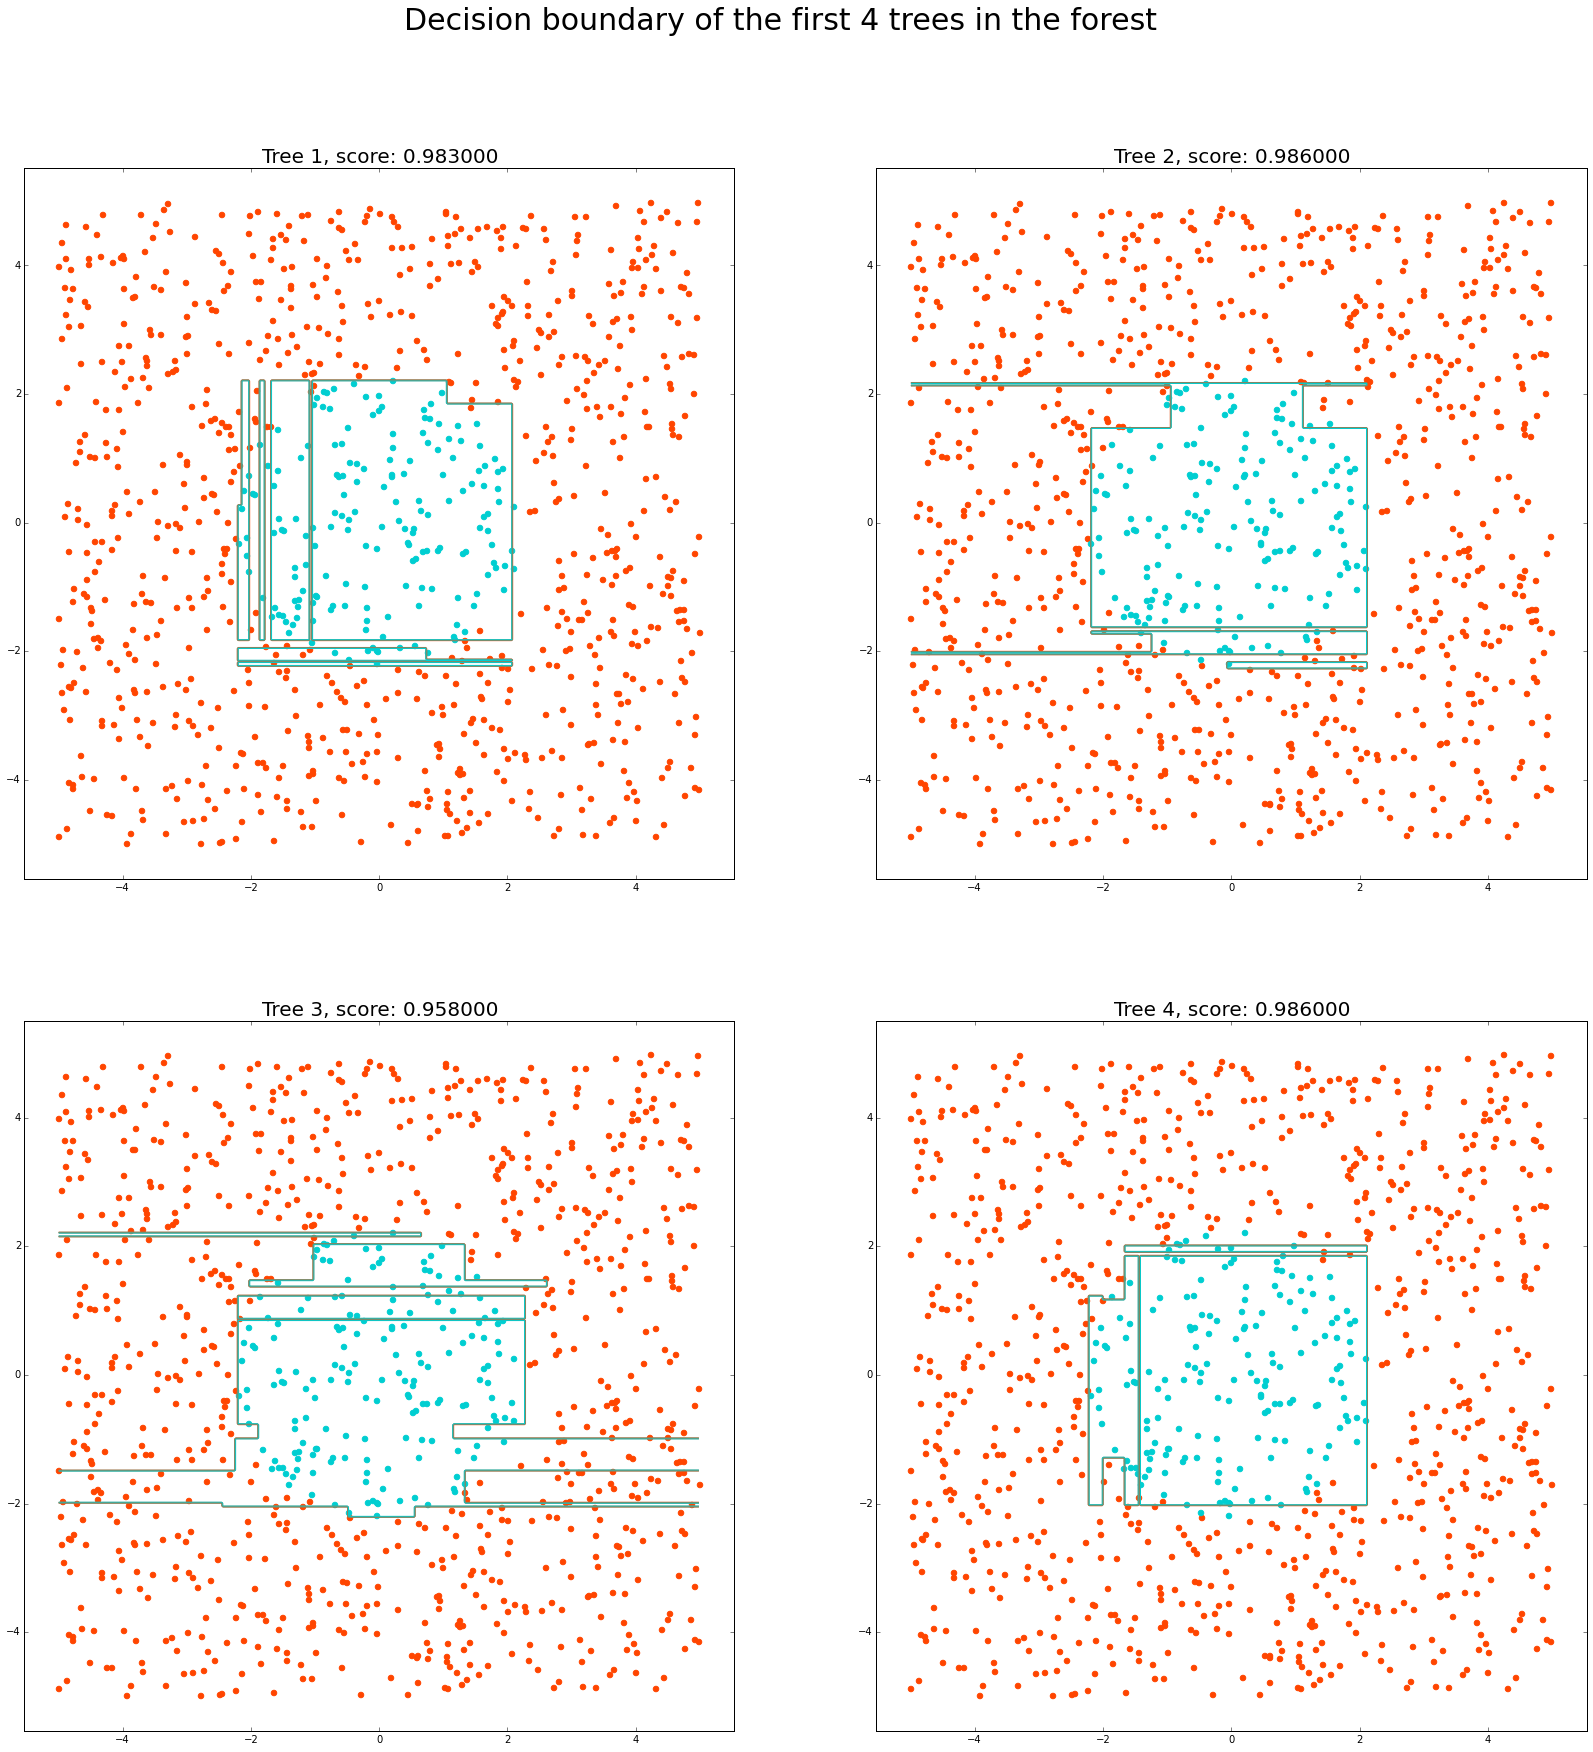

In [87]:
rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=8, random_state=101)
X = np.asarray(zip(xs, ys))
y = class1_mask.astype(int)

fig = plt.figure(figsize=(28, 28))

plot_idx = 1
forest = rfc.fit(X, y)
for tree in forest.estimators_[:4]:
    scores = tree.score(X, y)
    plt.subplot(2, 2, plot_idx)
    plt.title('Tree %d, score: %f' % (plot_idx, scores), fontsize=20)

    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    pred = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)
    cs = plt.contour(xx, yy, pred, colors=plot_colors, linewidth=10)

    # Plot the training points
    for i, c in zip(xrange(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=c, s=30)

    plot_idx += 1  # move on to the next plot in sequence

plt.suptitle('Decision boundary of the first 4 trees in the forest', fontsize=30)
plt.axis("tight")
plt.show()

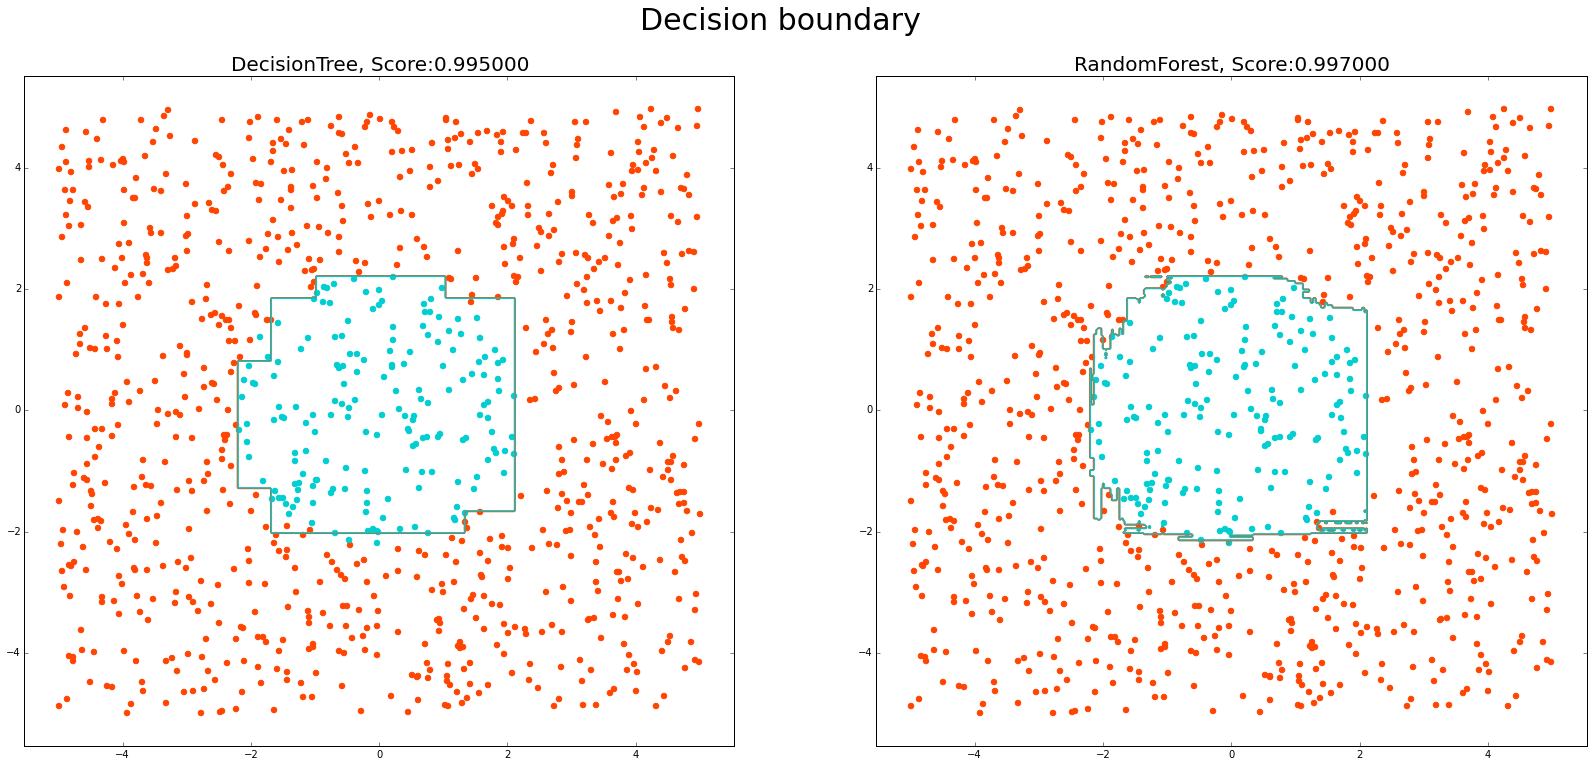

In [46]:
plot_idx = 1

models = [DecisionTreeClassifier(max_depth=8),
          RandomForestClassifier(n_estimators=n_estimators, max_depth=8, random_state=101)]

fig = plt.figure(figsize=(28, 12))

for model in models:
    X = np.asarray(zip(xs, ys))
    y = class1_mask.astype(int)

    clf = model.fit(X, y)
    scores = clf.score(X, y)

    model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")] + ", Score:%f" % scores
    plt.subplot(1, 2, plot_idx)
    if plot_idx <= len(models):
        # Add a title at the top of each column
        plt.title(model_title, fontsize=20)

    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)
    cs = plt.contour(xx, yy, pred, colors=plot_colors, linewidth=10)

    # Plot the training points
    for i, c in zip(xrange(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=c, s=30)

    plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Decision boundary", fontsize=30)
plt.axis("tight")

plt.show()

## Number of trees

Random Forest *typically* does **NOT** suffer from overfitting.

However, it will if there are many features that are just noise.

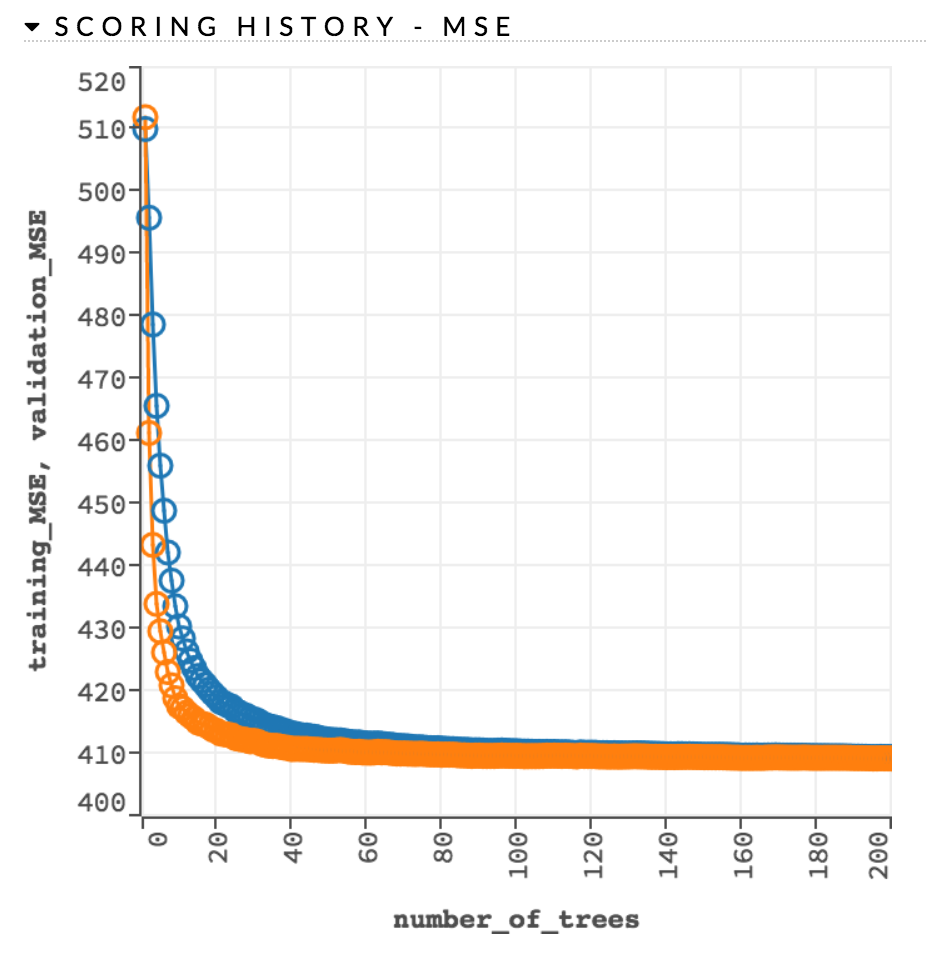

In [6]:
Image(filename='hero-intl-train.png', width=500)

## Summary

- Bagging: Improve accuracy by reducing variance
    - Sample the data (Bootstrap)
    - Sample the features for additional randomness
- Usually does not overfit
- OOB error rate on data left out

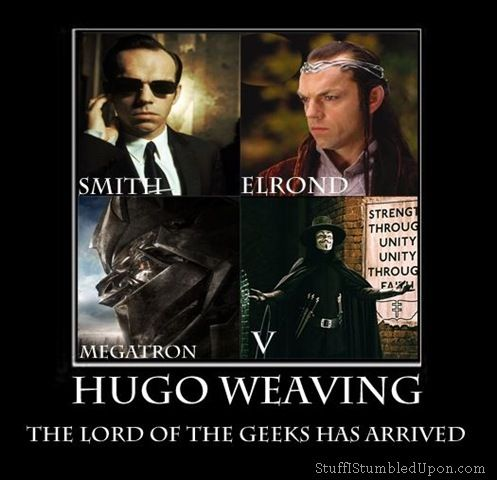

In [58]:
Image(filename='hugo-weaving.jpg')

# Gradient Boosting Trees

- **Boosting**: Iteratively add more trees to fix the place where the current model is doing badly
- **Gradient of loss function**: Each tree tries to decrease the loss function along the direction of its gradient (steepest descent); the next tree take the problem left over by the previous ones
- **Reduce bias**: Thus reducing total error
- Combine weak trees together, with weights

Code adapted from Peter Prettenhofer's notebook: 
http://nbviewer.ipython.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb

## Algorithm

Proposed by Jerome H. Friedman
![Jerome Friedman](https://statistics.stanford.edu/sites/default/files/styles/portrait/public/friedman_new.jpg) 

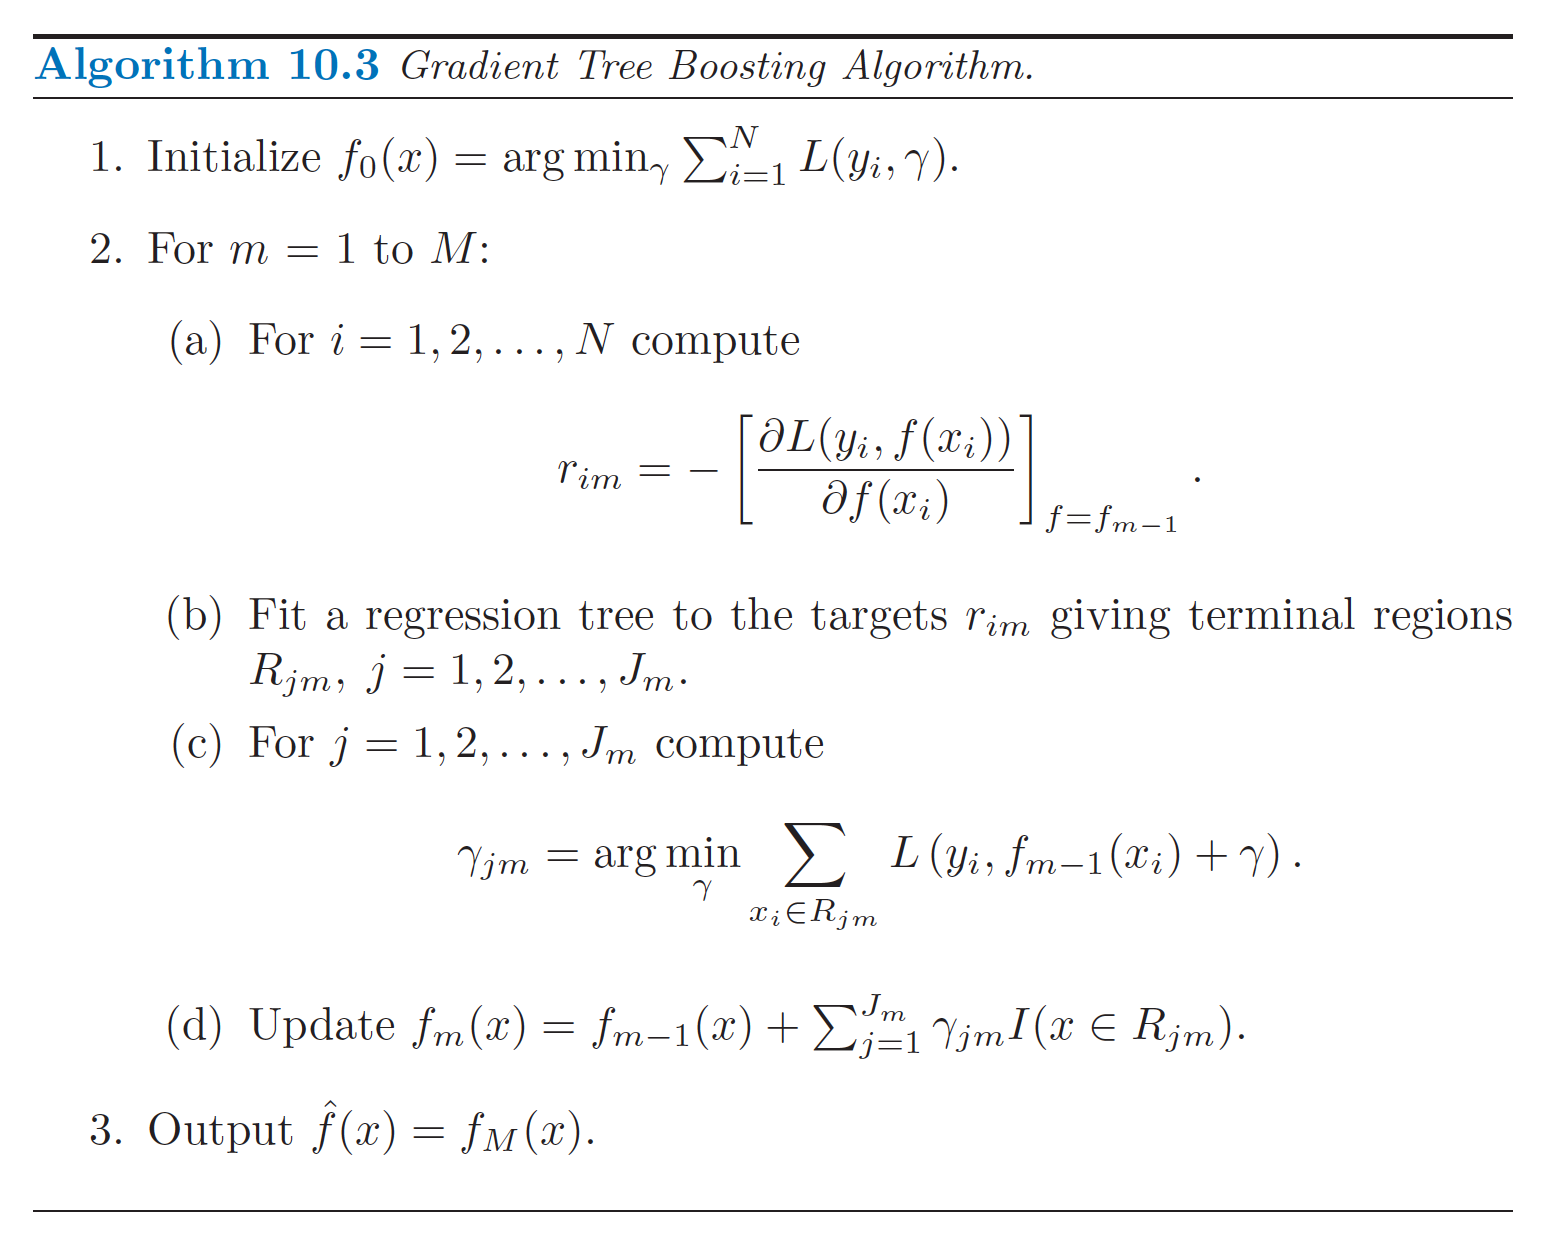

In [8]:
Image(filename='gradient-boost-tree.png', width=700)

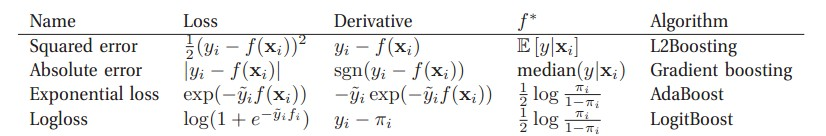

In [21]:
Image(filename='loss-and-gradient.jpeg')

In [ ]:
# Scikit-learn
class LeastSquaresError(RegressionLossFunction):
    def __call__(self, y, pred, sample_weight=None):
        return np.mean((y - pred.ravel()) ** 2.0)

    def negative_gradient(self, y, pred, **kargs):
        return y - pred.ravel()

class LeastAbsoluteError(RegressionLossFunction):
    def __call__(self, y, pred, sample_weight=None):
        return np.abs(y - pred.ravel()).mean()

    def negative_gradient(self, y, pred, **kargs):
        """1.0 if y - pred > 0.0 else -1.0"""
        pred = pred.ravel()
        return 2.0 * (y - pred > 0.0) - 1.0

In [ ]:
# XGBoost
inline float FirstOrderGradient(float predt, float label) const {
    switch (loss_type) {
        case kLinearSquare: return predt - label;
        case kLogisticRaw: predt = 1.0f / (1.0f + std::exp(-predt));
        case kLogisticClassify:
        case kLogisticNeglik: return predt - label;
        default: utils::Error("unknown loss_type"); return 0.0f;
    }
}

For our one feature regression problem, the algorithm becomes:
```
1. Initialize prediction f_0(x_i) = average of all y_i # fit a horizontal line
2. for m in range(1, num_trees + 1):
    a. for i in range(1, num_data_points + 1):
        # simply calculate the residue for the current model
        r_im = y_i - f_m(x_i)
    b. fit a regression tree to r_im, and get the leaves R_jm
    c. for each leaf node, set prediction f_jm = average of data points 
        in that leaf
    d. add the new tree to the ensemble
        f_m(x) = f_m-1(x) + sum(f_jm)
3. Return f_M(x)
```

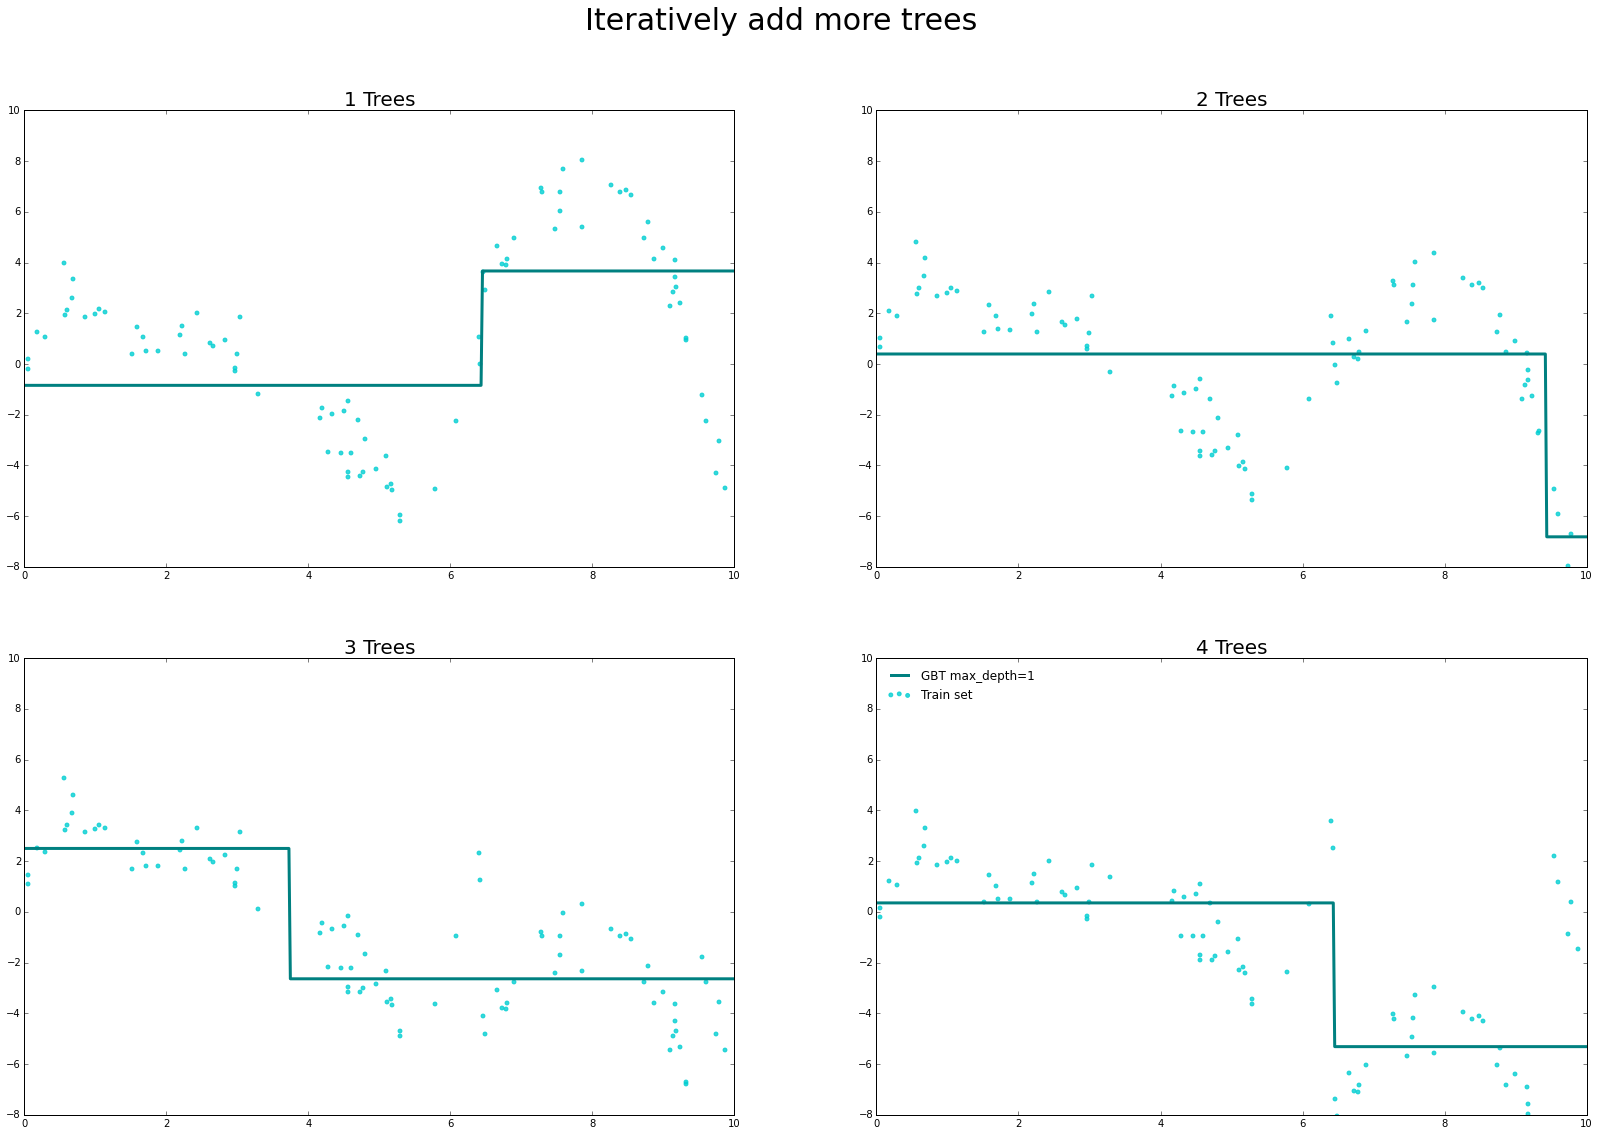

In [22]:
from itertools import islice

est = GradientBoostingRegressor(n_estimators=10, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

preds = list(est.staged_predict(X_train.ravel()[:, np.newaxis]))

# Compute the residues after each tree's prediction
residues = [y_train]
for tree_idx in range(3):
    residues.append(y_train - sum(preds[i] for i in range(0, tree_idx + 1)))

fig = plt.figure(figsize=(28, 18))

for tree_idx in range(4):
    plt.subplot(2, 2, tree_idx + 1)
    
    est = GradientBoostingRegressor(n_estimators=1, max_depth=1, learning_rate=1.0)
    est.fit(X_train, residues[tree_idx])

    pred_plot = est.predict(x_plot.ravel()[:, np.newaxis])
    plt.scatter(X_train, residues[tree_idx], s=15, alpha=0.8, color=c_turquoise, label='Train set')
    plt.plot(x_plot, pred_plot, color=c_teal, label='GBT max_depth=1', linewidth=3)
    
    plt.title('%d Trees' % (tree_idx + 1), fontsize=20)
    ax = plt.gca()
    ax.set_xlim(0, 10)
    ax.set_ylim(-8, 10)

plt.suptitle('Iteratively add more trees', fontsize=30)
plt.legend(loc='upper left', frameon=False)

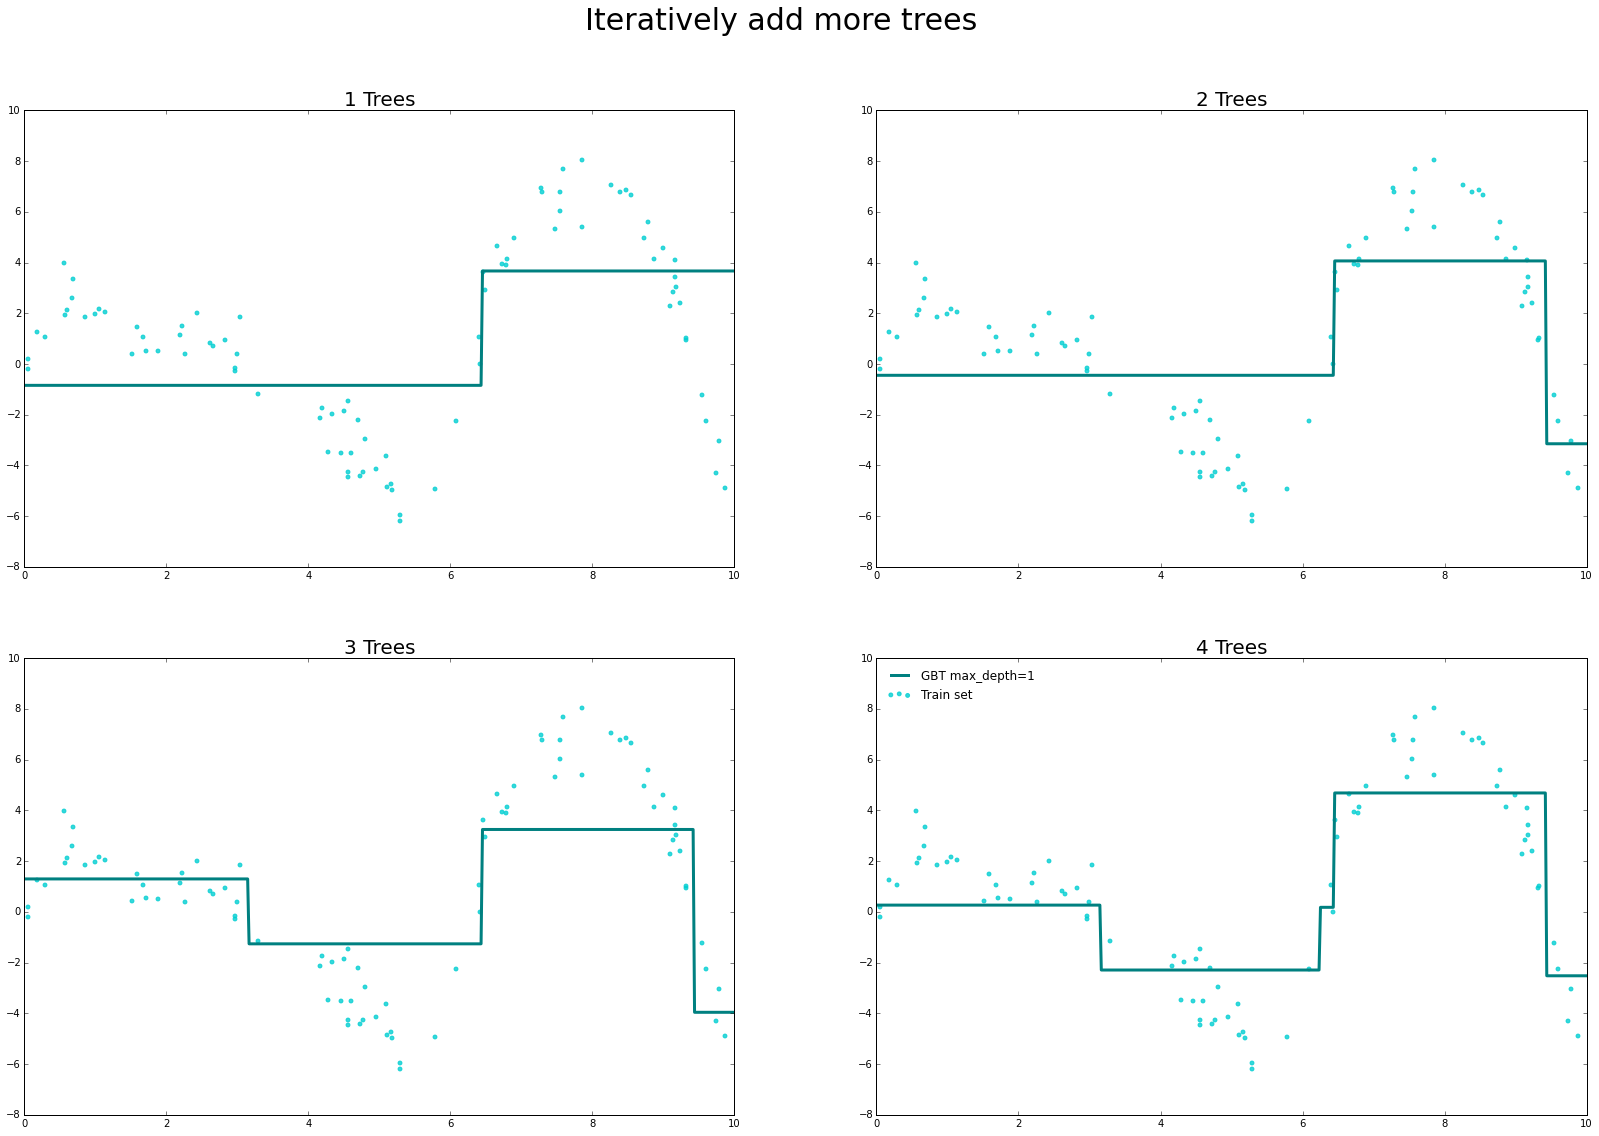

In [17]:
from itertools import islice

est = GradientBoostingRegressor(n_estimators=10, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

preds = list(islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 1))

fig = plt.figure(figsize=(28, 18))

for plot_idx in range(1, 5):
    plt.subplot(2, 2, plot_idx)
    
    pred = preds[plot_idx - 1]
    plt.scatter(X_train, y_train, s=15, alpha=0.8, color=c_turquoise, label='Train set')
    plt.plot(x_plot, pred, color=c_teal, label='GBT max_depth=1', linewidth=3)
    
    plt.title('%d Trees' % plot_idx, fontsize=20)
    ax = plt.gca()
    ax.set_xlim(0, 10)

plt.suptitle('Iteratively add more trees', fontsize=30)
plt.legend(loc='upper left', frameon=False)

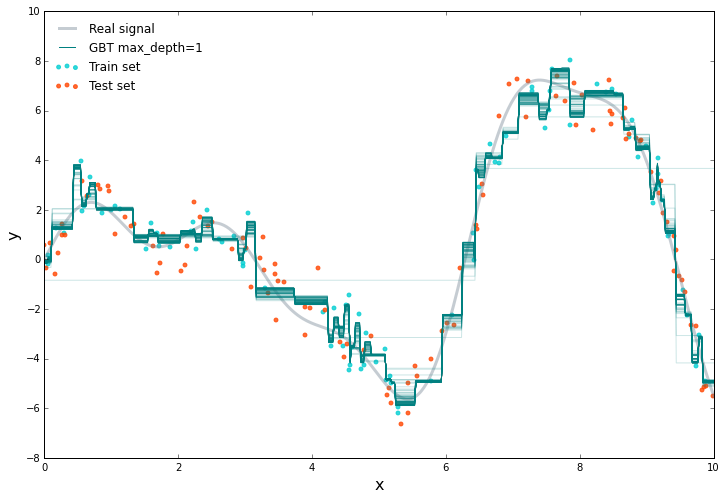

In [23]:
from itertools import islice

plot_data(plot_test=True)
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()

# step through prediction as we add 10 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color=c_teal, alpha=0.2)

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color=c_teal, label='GBT max_depth=1')

plt.legend(loc='upper left', frameon=False)

## Tree depth

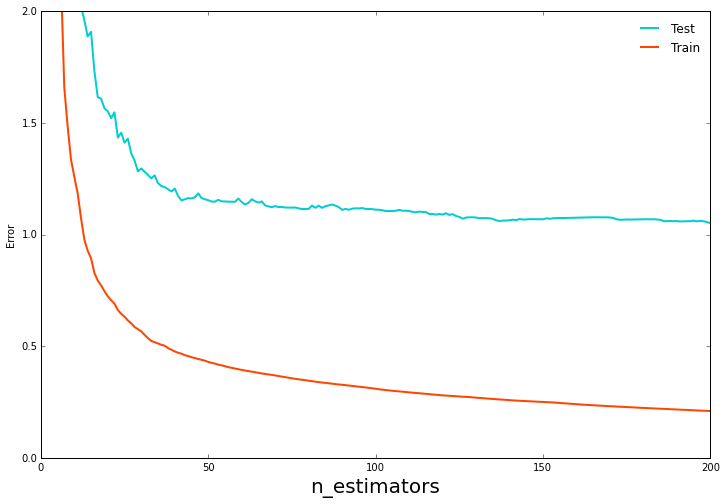

In [78]:
n_estimators = 200

def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

def deviance_plot(est, X_test, y_test, ax=None, label='',
                  train_color=c_orange_red, 
                  test_color=c_turquoise,
                  alpha=1.0, figsize=(12, 8)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)
    
    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
            linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
            label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators', fontsize=20)
    ax.set_ylim((0, 2))
    return test_dev, ax

est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right', frameon=False)

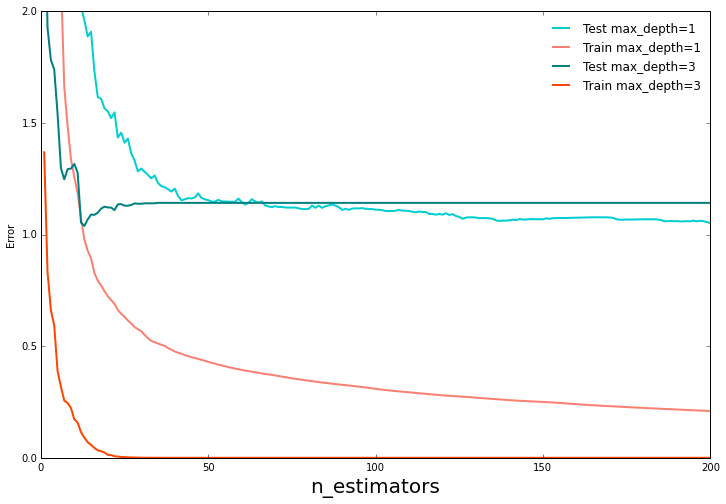

In [79]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
for params, (test_color, train_color) in [({'max_depth': 1}, (c_turquoise, c_salmon)),
                                          ({'max_depth': 3}, (c_teal, c_orange_red))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)

plt.legend(loc='upper right', frameon=False)

**Why stumps?** Because deeper trees mean more interactions between features
- Stump: `X<5?` -- No interaction between features
- Depth 2: `X<5 && Y>3?` -- 2nd order interaction between (X, Y)
- Depth 3: `X<5 && Y>3 && Z<20?` -- 3rd order interaction between (X, Y, Z)

## Learning rate

Slow down the learning (and overfitting)

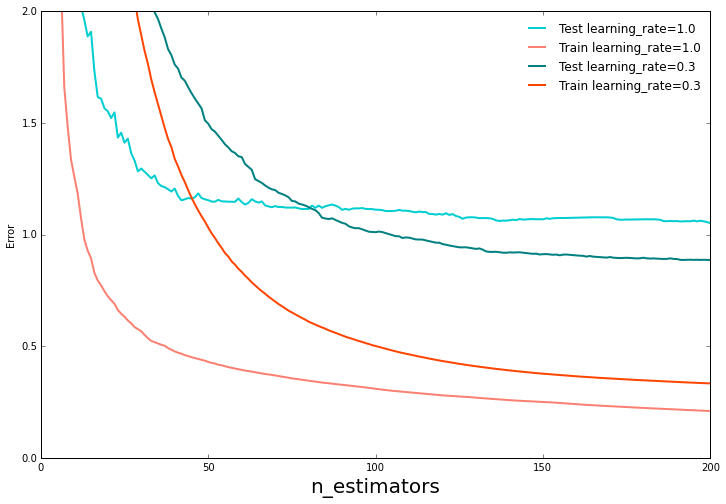

In [80]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
for params, (test_color, train_color) in [({'learning_rate': 1.0}, (c_turquoise, c_salmon)),
                                          ({'learning_rate': 0.3}, (c_teal, c_orange_red))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)

plt.legend(loc='upper right', frameon=False)

## Summary

- Boosting: Improve accuracy by reducing bias
- Will overfit
- Combine trees with weights

# Ensembling

Stack models together

## Combine Random Forest and Gradient Boost Trees!

Wait, what?

Yep, this is called **Stochastic Gradient Boost**: For each tree, use a subsample of the dataset to train.

We calculate the average loss function over the full dataset. But if we use a random sample of the dataset, the loss function is sort of stochastic, hence the name.

Usually combine it with shrinkage.

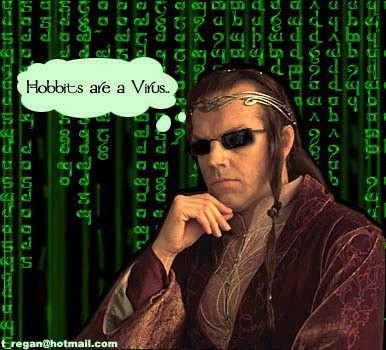

In [59]:
Image(filename='agent-elrond.jpg')

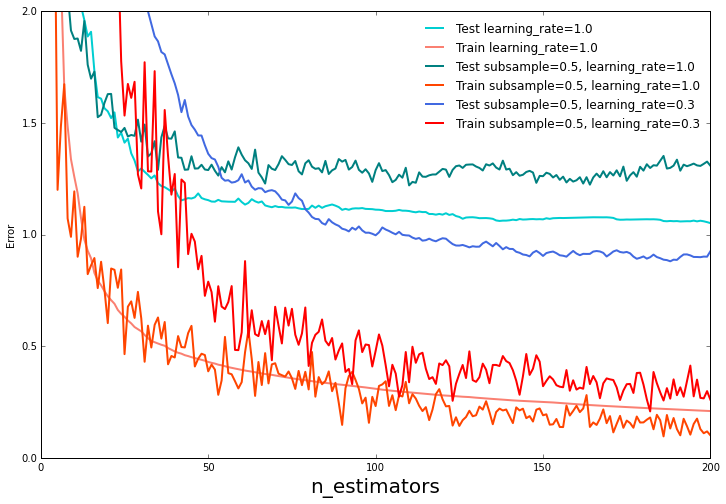

In [81]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
for params, (test_color, train_color) in [({'learning_rate': 1.0}, (c_turquoise, c_salmon)),
                                          ({'learning_rate': 1.0, 'subsample': 0.5}, (c_teal, c_orange_red)),
                                          ({'learning_rate': 0.3, 'subsample': 0.5}, (c_royal_blue, 'red'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)

plt.legend(loc='upper right', frameon=False)

## Other way of ensembling

## Regularization

We want **predictive** AND **simple** models.

Penalize complex model, favor simple ones, make feature importance sparse

## Lasso and Ridge regressions

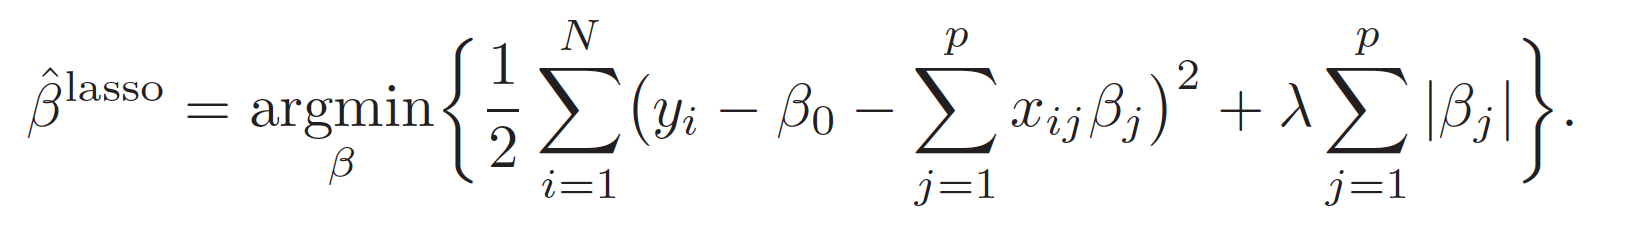

In [16]:
Image(filename='lasso.png', width=800)

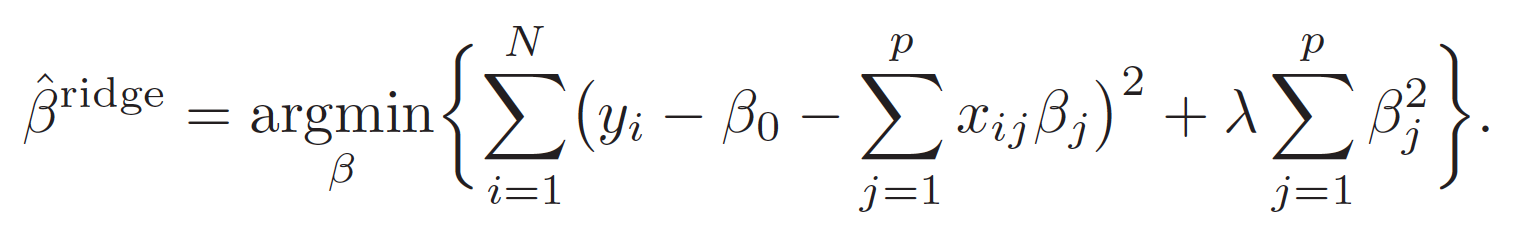

In [79]:
Image(filename='ridge.png', width=750)

## Importance Sampled Learning Ensemble (ISLE)

Basically post-process the trees with LASSO

Lasso'd Gradient Boosting Trees

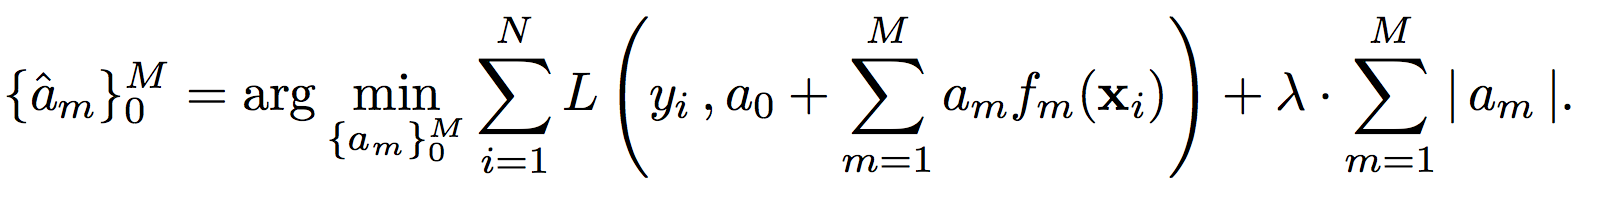

In [17]:
Image(filename='isle.png', width=800)

### When is it useful?

It reduces the number of trees while preserving the predicting power, which means that in production the scoring can be **faster**!

# XGBoost

It performs well, and it's fast. But WHY?

## Models complexity
Explicitly takes into account model complexity (which is often poorly done or completely ignored in other implementations)

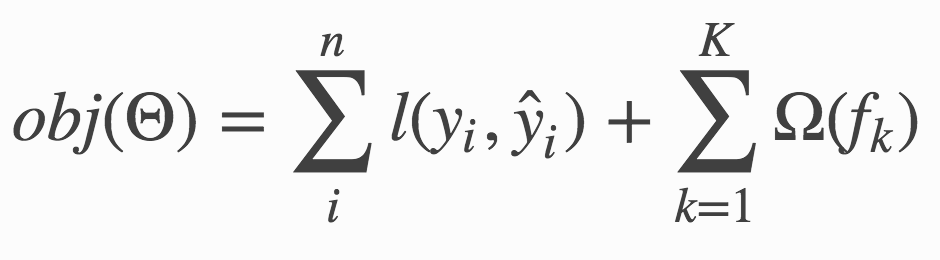

In [32]:
Image(filename='xgboost-obj.png', width=400)

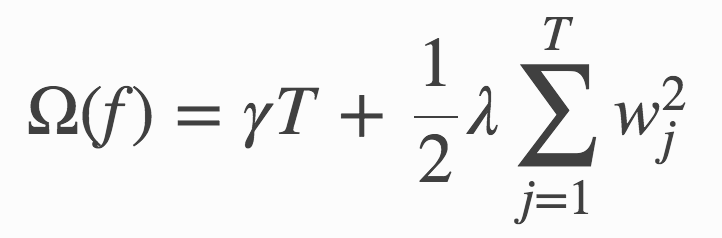

In [34]:
Image(filename='xgboost-complexity.png', width=300)

## Faster optimization
Employ **Newton's method** (or its approximation, e.g. BFGS), which uses the 2nd order derivative (information on the curvature) of the loss function to inform the search. It approximates the function by the 2nd order Taylor expansion,

$$f(x+\Delta x) \approx f(x) + \Delta x f'(x) + \frac{1}{2} \Delta x^2 f''(x)$$

Compared to gradient (steepest) descent, this method is more expensive **per step** but *might* result in **much fewer steps**.

Oh, did I say it's written in **C++**?

Loss function: MSE


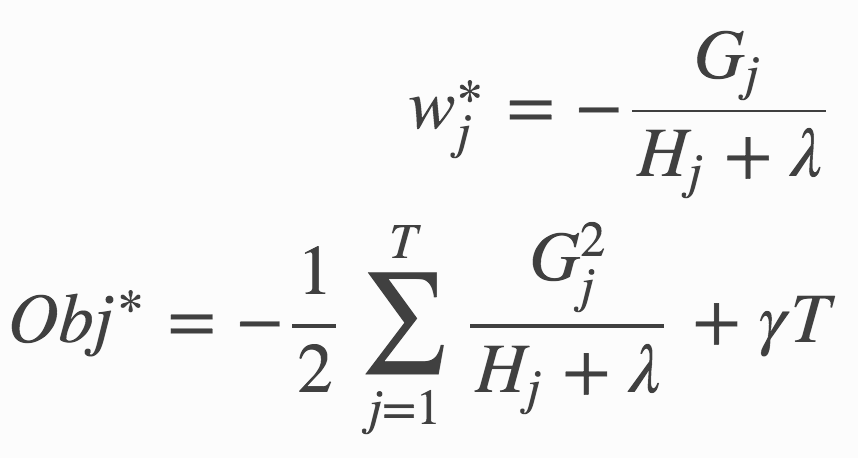

In [25]:
print('Loss function: MSE')
Image(filename='xgboost-best.png', width=300)

## Newton's method vs. Gradient descent

Let's take a parabola as the example:
$$y=(x-2)^2$$

Compute the first order derivative (the gradient):
$$y'(x)=\frac{dy}{dx}=2(x-2)$$

Compute the second order derivative (the Hessian matrix):
$$y''(x)=\frac{d^2y}{dx^2} = 2$$

Gradient does the search
$$x_{n+1} = x_n - \delta y'(x_n) $$

While Newton's method does the search
$$x_{n+1} = x_n - \frac{y'(x_n)}{y''(x_n)} $$

In [124]:
def y(x):
    return (x - 2.) ** 2

def y_prime(x):
    return 2. * (x - 2)

def y_double_prime(x):
    return 2.

# Set initial condition
x0 = -10
y0 = y(x0)
delta = 0.9

# Do the gradient descent
cur_x, cur_y = x0, y0
xs_gd, ys_gd = [cur_x], [cur_y]
while (cur_y > 1e-5 and len(xs_gd) < 100):
    cur_x = cur_x - delta * y_prime(cur_x)
    cur_y = y(cur_x)
    xs_gd.append(cur_x)
    ys_gd.append(cur_y)

# Do Newton's method
cur_x, cur_y = x0, y0
xs_nm, ys_nm = [cur_x], [cur_y]
while (cur_y > 1e-5 and len(xs_nm) < 100):
    cur_x = cur_x - y_prime(cur_x) / y_double_prime(cur_x)
    cur_y = y(cur_x)
    xs_nm.append(cur_x)
    ys_nm.append(cur_y)


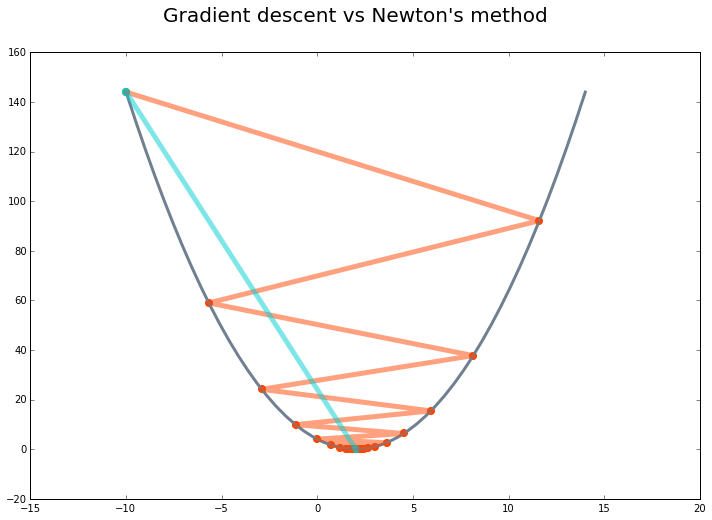

In [125]:
x_plot = np.linspace(-10, 14)
y_plot = (x_plot - 2) ** 2

fig = plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, label='$y = (x-2)^2$',
         alpha=1, linewidth=3, color=c_grey)

plt.scatter(xs_gd, ys_gd, s=50, color=c_orange_red)
plt.plot(xs_gd, ys_gd, linewidth=5, color=c_orange_red, alpha=0.5)

plt.scatter(xs_nm, ys_nm, s=50, color=c_turquoise)
plt.plot(xs_nm, ys_nm, linewidth=5, color=c_turquoise, alpha=0.5)

plt.suptitle("Gradient descent vs Newton's method", fontsize=20)

In [ ]:
  inline float FirstOrderGradient(float predt, float label) const {
    switch (loss_type) {
      case kLinearSquare: return predt - label;
      case kLogisticRaw: predt = 1.0f / (1.0f + std::exp(-predt));
      case kLogisticClassify:
      case kLogisticNeglik: return predt - label;
      default: utils::Error("unknown loss_type"); return 0.0f;
    }
  }
  /*!
   * \brief calculate second order gradient of loss, given transformed prediction
   * \param predt transformed prediction
   * \param label true label
   * \return second order gradient
   */

  inline float SecondOrderGradient(float predt, float label) const {
    // cap second order gradient to postive value
    const float eps = 1e-16f;
    switch (loss_type) {
      case kLinearSquare: return 1.0f;
      case kLogisticRaw: predt = 1.0f / (1.0f + std::exp(-predt));
      case kLogisticClassify:
      case kLogisticNeglik: return std::max(predt * (1.0f - predt), eps);
      default: utils::Error("unknown loss_type"); return 0.0f;
    }
  }


# With all that said...

Knowing these is perfectly useless towards predicting GB of online coupons or winning a Kaggle competition. We still need the hands-on experience.

# References

- *Elements of Statistical Learning*, **Trevor Hastie** (laid foundation of R), **Robert Tibshirani** (inventor of Lasso), **Jerome Friedman** (inventor of Gradient Boosting Machines)![](http://ecx.images-amazon.com/images/I/41LeU3HcBdL._SY344_BO1,204,203,200_.jpg)

- http://scott.fortmann-roe.com/docs/BiasVariance.html, **Scott Fortmann-Roe**

- http://nbviewer.ipython.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb, **Peter Prettenhofer**

- Scikit Learn

- XGBoost

# Other notes

## Standard error of sample vs sample size

Standard error (standard deviation of the sample mean) decreases as sample size increase.

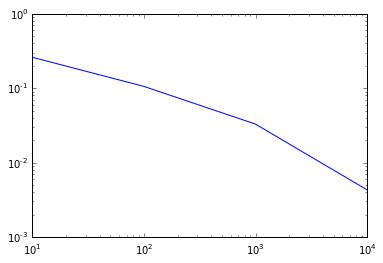

In [19]:
import numpy as np

stds = []
for n_samples in [10, 100, 1000, 10000]:
    sample_means = []
    for n_avgs in range(10):
        sample_means.append(np.mean(np.random.normal(0, 1, size=n_samples)))
    stds.append(np.std(sample_means))

plt.plot([10, 100, 1000, 10000], stds)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

## L-BFGS method

Broyden-Fletcher-Goldfarb-Shanno

- Newton-Ralphson method: Approximate function with 2nd order Taylor expansion; requires 2nd order derivative (Hessian matrix)
- Quasi Newton's method: Approximate Hessian matrix with gradient, given input and gradient deltas, so we don't have to compute Hessian
- BFGS method: Secant condition, only requires the history of input and gradient
- L-BFGS: Truncate input and gradient history

In [219]:
from sklearn.ensemble import RandomForestRegressor

bias_sqr, variance = [], []
# for n_est in range(1, 20):
model = RandomForestRegressor(n_estimators=20).fit(X_train, y_train)
pred = model.predict(X_test)
print (sum(y_test - np.mean(pred))) ** 2, np.var(pred), np.var(y_test)
print sum((pred - y_test) ** 2)

66.0544301133 13.6690393045 14.9158256778
118.187558486
